# Consumer preferences: Using time series analysis for sales and demand forecasting

**Project Summary: Time Series Forecasting for Sales and Demand**

In this project I explore how time series analysis can help forecast book sales and demand. By examining historical sales data, the aim is to produce accurate forecasts that support better business decisions—helping reduce costs, optimise stock, and maximise profit.

Using data from Nielsen BookScan, the world’s leading book sales tracking service, I will clean and analyse real sales records. I will then apply models such as ARIMA or deep learning to uncover trends and seasonal patterns.

**Business Objective**

Nielsen is looking to develop a new service for small and medium-sized publishers who want data-driven insights to guide investments in new titles. This project supports that goal by identifying books with strong sales potential and useful patterns, helping publishers make smarter decisions about reprints, stock, and marketing.

**The Data**

Two datasets are used: a UK weekly sales timeline and an ISBN list. After cleaning, sales data is transformed into time series with missing values replaced by 0. Focus is on two books: The Alchemist and The Very Hungry Caterpillar.

**Methodology**

For the analysis of book sales I employ various methods, leveraging advanced time series modelling techniques to uncover trends, identify seasonality, and forecast future sales. The work on the two selected books aims at predicting the last 32 weeks of sales:

**1) Book Trends Analysis Overview**

Time series charts reveal trends and seasonality across ISBNs.

**2) Classical Techniques to Time Series Modelling**

The time series modelling starts with *STL decomposition* to analyse trends and seasonality. Residuals are evaluated using ACF and PACF to identify autocorrelation patterns and if past sales influence current sales, followed by a stationarity check to assess the need for differencing. *Auto ARIMA* is then applied for initial forecasts.

**3) Machine Learning and Deep Learning Techniques**

*XGBoost* and *LSTM* are applied. Data preparation includes creating lagged features, rolling window statistics, and scaling. For the LSTM model, time series data is also converted into sequences of input-output pairs with a structure of samples, timesteps, features.

In [ ]:
!pip install statsmodels
!pip install pmdarima
!pip install xgboost
!pip install keras-tuner
!pip install openpyxl
!pip install prophet
!pip install keras-tuner


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from plotly.subplots import make_subplots


from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
from tabulate import tabulate
from prophet import Prophet
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch, Hyperband
from itertools import product

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from keras_tuner import HyperModel, BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
# Ignore all FutureWarnings
warnings.simplefilter("ignore", category=FutureWarning)

Importing the data

In [ ]:
df_isbn_raw = pd.read_csv('/content/sample_data/df_isbn_raw.csv', header=0)
df_trend_raw = pd.read_csv('/content/sample_data/df_trend_raw.csv', header=0)

# Part 1: Data Preparation and initial Data Analysis

In [ ]:
df_trend = df_trend_raw.copy()
df_trend_raw.columns = df_trend_raw.columns.str.lower().str.replace(' ', '_')

# TREND: cleaning the data
df_trend = df_trend_raw[['end_date', 'isbn', 'title', 'volume', 'value','product_class','publisher_group', 'binding']].copy()
df_trend['isbn'] = df_trend['isbn'].astype(str)
df_trend['end_date'] = pd.to_datetime(df_trend['end_date'])
df_trend.set_index('end_date', inplace=True)
df_trend.sort_index(inplace=True)

**Resample the data and fill in missing values with 0, such that even weeks with 0 sales is represented.**

In [ ]:
# Resample by week, for each 'isbn', summing the 'volume' and 'value' columns, and filling missing values with 0
df_resampled = df_trend.groupby(['isbn','product_class','publisher_group', 'binding']).resample('W')[['volume', 'value']].sum().reset_index()
df_resampled.fillna({'volume': 0, 'value': 0}, inplace=True)

In [ ]:
df_resampled.head()

,isbn,product_class,publisher_group,binding,end_date,volume,value
0,9780001713031,Y4.2 Reference & Home Learning,HarperCollins Grp,Paperback,2001-01-07,522,2544.07
1,9780001713031,Y4.2 Reference & Home Learning,HarperCollins Grp,Paperback,2001-01-14,379,1842.21
2,9780001713031,Y4.2 Reference & Home Learning,HarperCollins Grp,Paperback,2001-01-21,393,1921.19
3,9780001713031,Y4.2 Reference & Home Learning,HarperCollins Grp,Paperback,2001-01-28,369,1785.31
4,9780001713031,Y4.2 Reference & Home Learning,HarperCollins Grp,Paperback,2001-02-04,423,2060.07


In [ ]:
df_resampled.isna().any()

,0
isbn,False
product_class,False
publisher_group,False
binding,False
end_date,False
volume,False
value,False


All data is now populated with no missing values.

**Checking volumes distribution by period.**

In this part of the analysis, I display data trends by breaking down the timeline into two distinct periods (12-24 years, 1-12 years)

In [ ]:
# Filtering data for the two analysis periods and grouping the data by month using sum of volumes
period1 = df_resampled[df_resampled['end_date'].dt.year.between(2001, 2012)]
period2 = df_resampled[df_resampled['end_date'].dt.year.between(2013, 2024)]

monthly_volumes_period1 = period1.groupby(period1['end_date'].dt.to_period("M"))['volume'].sum().reset_index()
monthly_volumes_period2 = period2.groupby(period2['end_date'].dt.to_period("M"))['volume'].sum().reset_index()

monthly_volumes_period1['end_date'] = monthly_volumes_period1['end_date'].dt.to_timestamp()
monthly_volumes_period2['end_date'] = monthly_volumes_period2['end_date'].dt.to_timestamp()

Plotting the data

In [ ]:
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=False,
    subplot_titles=[
        'Book Sales Trends (2001–2012 vs 2013–2024)',
        'Monthly Book Sales (12–24 Years: 2001–2012)',
        'Monthly Book Sales (1–12 Years: 2013–2024)'
    ]
)

# Chart (2001–2012 vs 2013–2024)
fig.add_trace(
    go.Scatter(
        x=monthly_volumes_period1['end_date'],
        y=monthly_volumes_period1['volume'],
        mode='lines+markers',
        name='2001–2012 (Monthly)',
        line=dict(color='blue'),
        marker=dict(size=6)
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=monthly_volumes_period2['end_date'],
        y=monthly_volumes_period2['volume'],
        mode='lines+markers',
        name='2013–2024 (Monthly)',
        line=dict(color='green'),
        marker=dict(size=6)
    ),
    row=1, col=1
)

# Monthly data chart for 12–24 years
fig.add_trace(
    go.Scatter(
        x=monthly_volumes_period1['end_date'],
        y=monthly_volumes_period1['volume'],
        mode='lines+markers',
        name='12–24 Years (Monthly)',
        line=dict(color='purple'),
        marker=dict(size=6)
    ),
    row=2, col=1
)

# Monthly data chart for 1–12 years
fig.add_trace(
    go.Scatter(
        x=monthly_volumes_period2['end_date'],
        y=monthly_volumes_period2['volume'],
        mode='lines+markers',
        name='1–12 Years (Monthly)',
        line=dict(color='orange'),
        marker=dict(size=6)
    ),
    row=3, col=1
)

fig.update_layout(
    title='Monthly Book Sales Trends',
    xaxis_title='Date',
    yaxis_title='Total Volume Sold',
    xaxis=dict(
        tickmode='auto',
        tickformat="%Y-%m",
        tickangle=45
    ),
    yaxis=dict(title='Total Volume'),
    legend=dict(title='Time Period'),
    template='plotly_white',
    font=dict(size=12),
    title_font=dict(size=16),
    hovermode='x unified',
    height=1000
)

fig.show()

The sales trend shows a sharp spike around 2001–2002, reaching over 8 million in total volume.
After the peak, sales dropped significantly and remained low and steady new baseline throughout the rest of the period (2001-2012).

Compared to the earlier period, sales volumes are much lower during 2013-2024.
While the overall trend is flat in this combined view, and a closer inspection (lower charts) reveals periodic fluctuations.

**Middle Chart:** Monthly Book Sales (12–24 Years: 2001–2012)

The massive spike in sales is clearly centered around 2001–2002, followed by a rapid decline.
From 2003 onwards, the monthly sales stabilized at a much lower baseline, with minimal variation.
Possible Reasons:

The spike could correspond to significant events like the release of popular books, changes in market demand, or one-time bulk orders.
The subsequent decline might indicate market saturation or shifting consumer behavior.

**Bottom Chart:** Monthly Book Sales (1–12 Years: 2013–2024)

Sales volumes in this period are significantly smaller compared to the earlier period (in the range of tens of thousands instead of millions).
There are periodic spikes in sales, especially around 2016–2019 and 2020–2023. These could indicate seasonal trends, promotional periods, or new product launches.
A dip in 2020 suggests an external disruption (e.g., COVID pandemic impact), followed by a recovery in subsequent years.

***Overall Observations:***

**Sharp Decline-** The most striking feature is the dramatic decrease in sales volume between the periods 2001-2012 and 2013-2024. Sales volume in the later period is significantly lower compared to the earlier one.

**Fluctuations-** Both periods exhibit fluctuations in sales volume. These fluctuations might be due to various factors such as seasonality (e.g., holiday sales), promotional events, and the popularity of specific books. **COVID and pandemic** have also impacted sales --> 0 sales are recorded during lockdown period.

**Possible Seasonality-** There appears to be some recurring patterns in the fluctuations, suggesting the presence of seasonality.

***Interpretation and Possible Factors:***

**Market Shift-** The significant drop in sales volume from 2013-2024 could indicate a major shift in the book market. This could be attributed to factors such as **rise of E-books and Digital Platforms:** The increasing popularity of e-books and digital reading platforms like Kindle and Audible might have diverted readers away from physical books.
**Changing Consumer Behavior-** Changes in consumer preferences, such as a shift towards streaming services and online entertainment, could have reduced demand for physical books.
**Economic Factors:** Economic downturns or changes in consumer spending habits could have impacted book sales.


***Further Analysis:***

**Seasonality** to identify impact of seasonality on sales.

**External Factors-** Analysing the impact of external factors, such as economic indicators, cultural trends, and technological advancements, could provide further insights into the sales trends.


**Filter out the ISBNs (from all four tabs) wherein sales data exists beyond 2024-07-01.**

From this part of the work, I will focus on ISBNs with sales data beyond 2024-07-01 to capture the trends of the books with most recent sales.

In [ ]:
cutoff_date = pd.Timestamp("2024-07-01")
valid_isbns = df_trend[df_trend.index >= cutoff_date]['isbn'].unique()
filtered_df = df_resampled[df_resampled['isbn'].isin(valid_isbns)]

There are 61 isbns captured by the applied filter.

###Checking insights: investigating consumers preferences by Product Class


In [ ]:
filtered_df['end_date'] = pd.to_datetime(filtered_df['end_date'])

def filter_by_time_range(df, time_range):
    current_date = datetime.today()

    if time_range == '12-24 years':
        start_date = current_date - timedelta(weeks=24 * 52)  # 24 years ago
        end_date = current_date - timedelta(weeks=12 * 52)  # 12 years ago
    elif time_range == '1-12 years':
        start_date = current_date - timedelta(weeks=12 * 52)  # 12 years ago
        end_date = current_date - timedelta(weeks=1)  # Last week
    else:
        return df

    return df[(df['end_date'] >= start_date) & (df['end_date'] <= end_date)]

# Aggregating the data by year and product class
filtered_df['year'] = filtered_df['end_date'].dt.year
yearly_data = filtered_df.groupby(['year', 'product_class'])['volume'].sum().reset_index()

sorted_classes = (
    yearly_data.groupby('product_class')['volume']
    .sum()
    .sort_values(ascending=False)
    .index
)

time_ranges = {
    '12-24 years': '12-24 years',
    '1-12 years': '1-12 years'
}

figs = {}

for time_label, time_value in time_ranges.items():
    filtered_data = filter_by_time_range(filtered_df, time_value)

    filtered_data['year'] = filtered_data['end_date'].dt.year
    yearly_data = filtered_data.groupby(['year', 'product_class'])['volume'].sum().reset_index()

    fig = go.Figure()

    for product_class in sorted_classes:
        class_data = yearly_data[yearly_data['product_class'] == product_class]
        fig.add_trace(go.Bar(
            x=class_data['year'],
            y=class_data['volume'],
            name=product_class,
        ))

    fig.update_layout(
        barmode='stack',
        title=f'Sales Volume by Product Class ({time_label})',
        xaxis_title='Year',
        yaxis_title='Volume',
        xaxis=dict(type='category'),
        legend_title='Product Class',
    )

    figs[time_label] = fig

for time_label, fig in figs.items():
    fig.show()

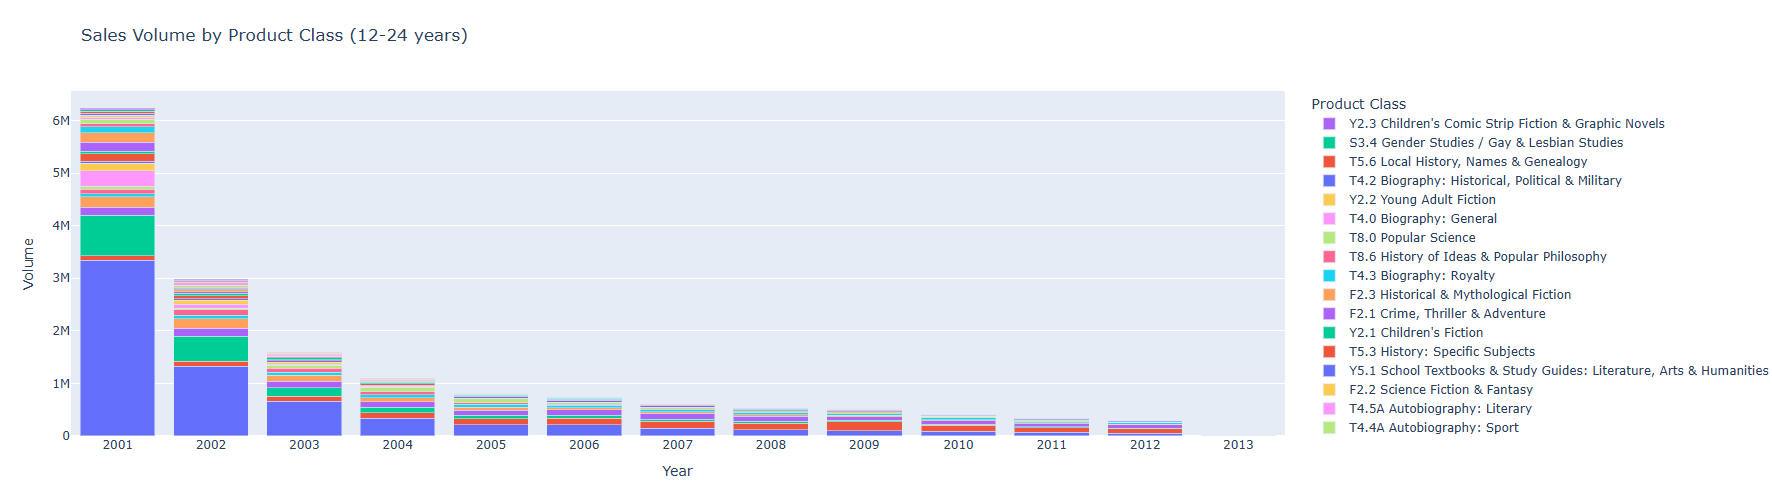

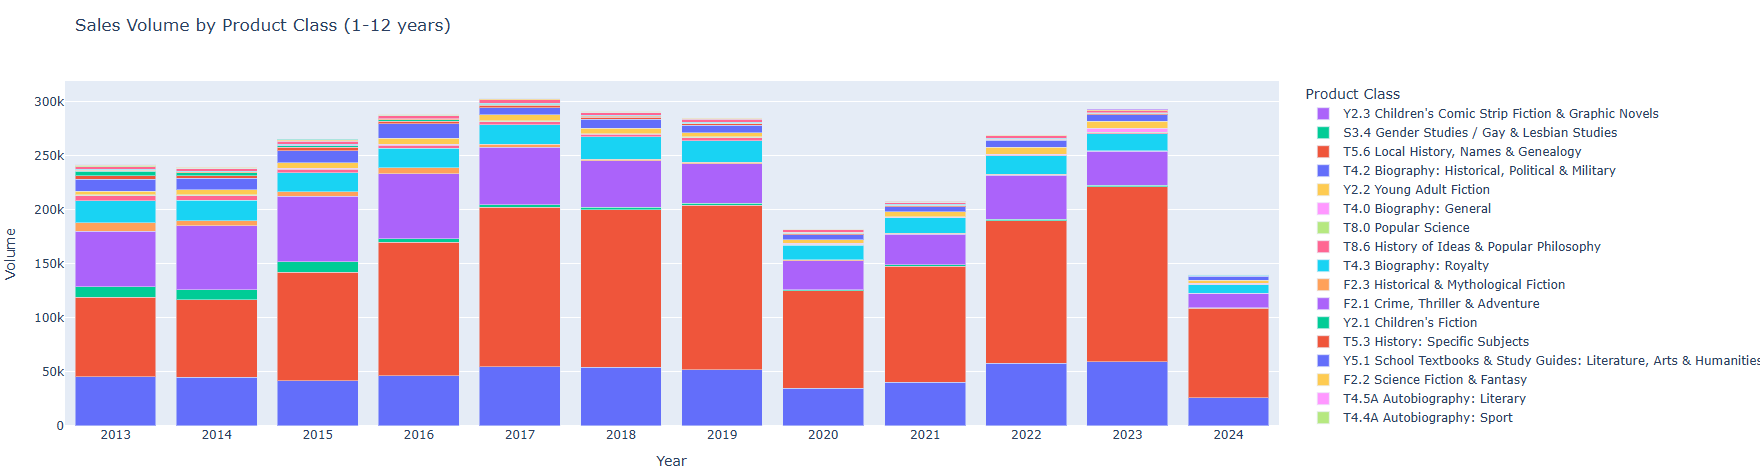

The charts display sales volume by product class over the two identified  time periods:

Top Chart (12–24 years): sales volume is significantly higher in 2001 and 2002 compared to later years. After 2003, sales volume shows a sharp decline, stabilising at much lower levels until 2013.

**Product Class Distribution:**
A wide variety of product classes are represented. However, certain classes like "General and Literary Fiction" and "Travel Writing" dominate in the earlier years.

Timeframe: 2013 to 2024
Trend: sales volumes are generally steady from 2013 to 2019, with slight increases. A notable rise occurs after 2020, peaking in 2022 and 2023.

**Product Class Distribution:**
The distribution across product classes appears more consistent during the last 12 years, with some classes like "Picture Books", "School Texbooks & Study Guides", "Careers and Success" clearly dominating (topics of self-control, well-being, happiness, growth and change appear to be a growing trend in the more recent years).

***Key Observations:***
Differences in Sales Volume: The earlier period (12–24 years) shows a drastic decline in sales after 2001, while the recent period (1–12 years) shows steadier sales overall.

Certain product classes have consistently higher sales contributions and consumer product preferences clearly have changed over the years.

###Further insights


<ipython-input-50-857f1998fb8b>:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-50-857f1998fb8b>:36: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



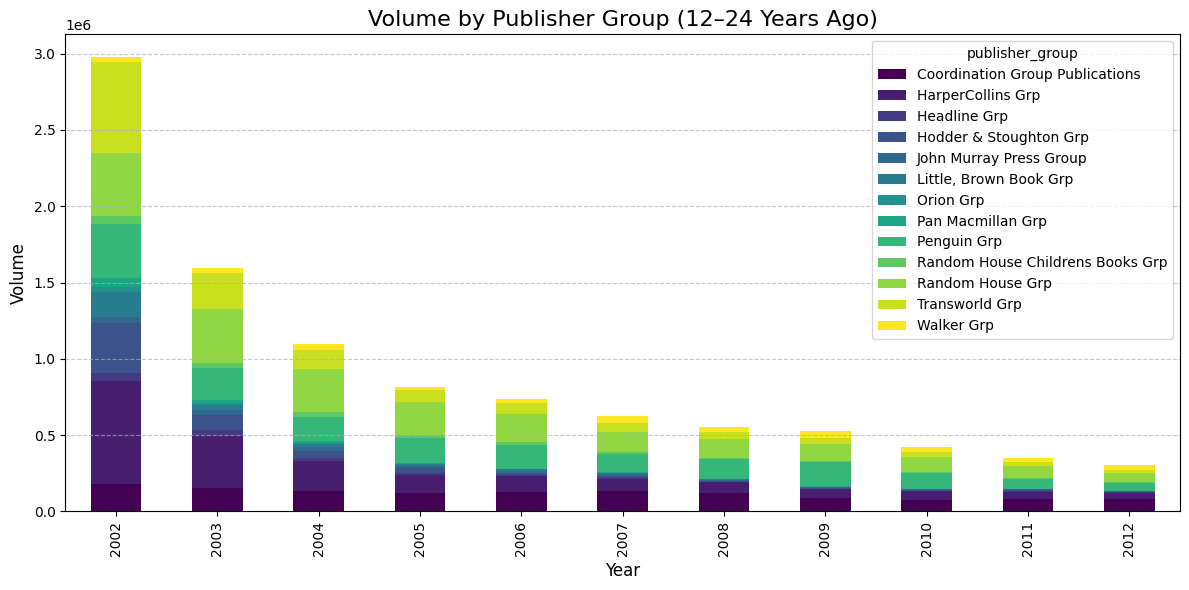

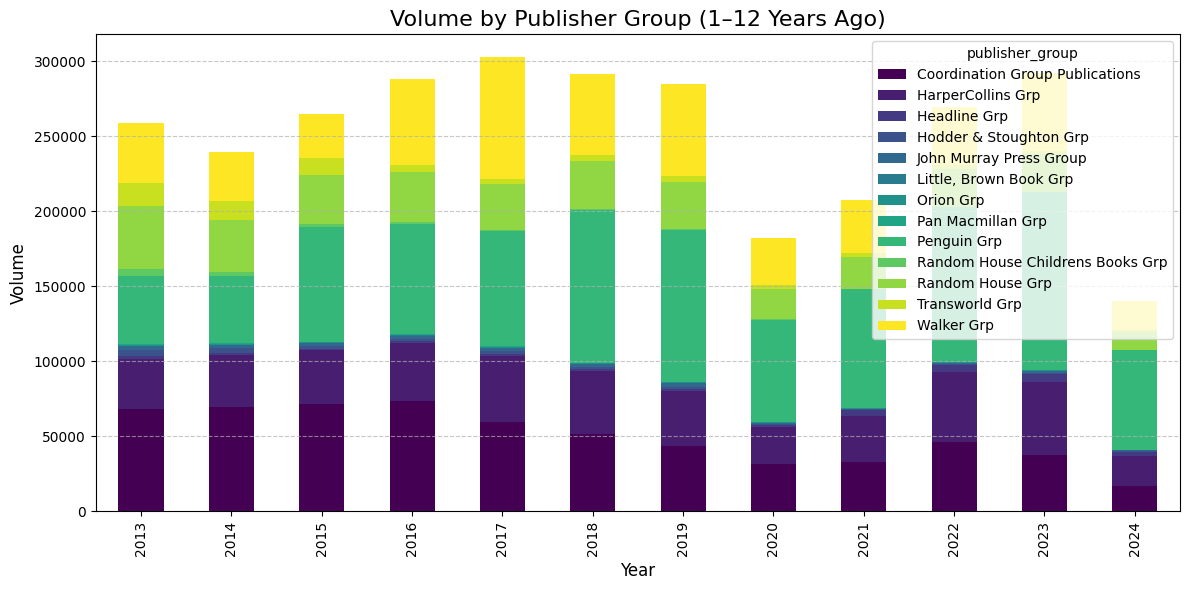

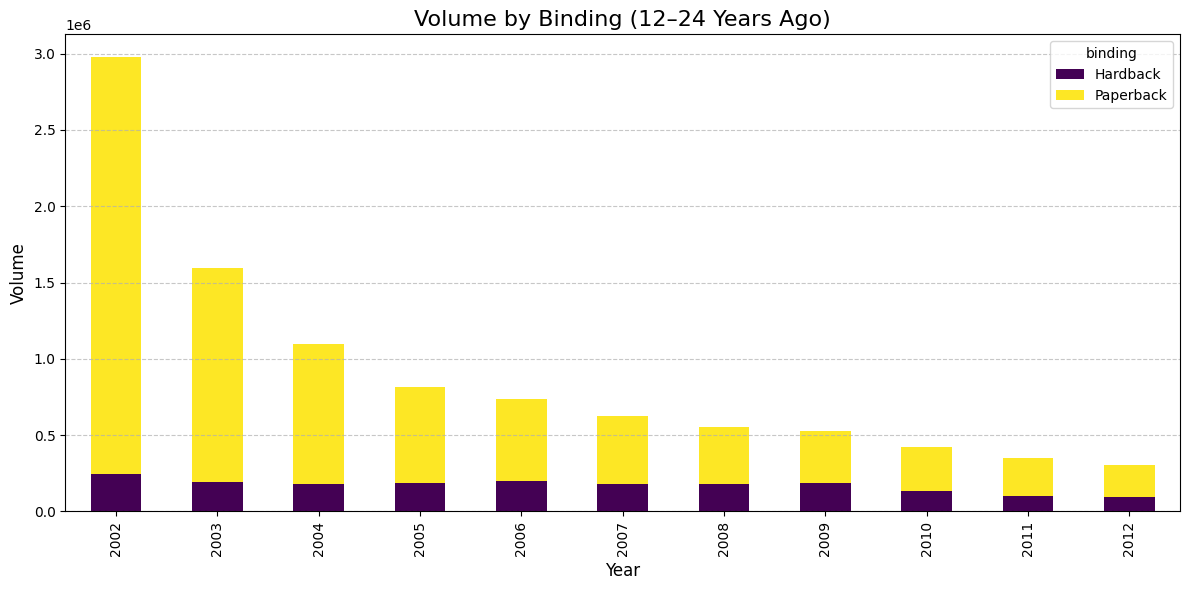

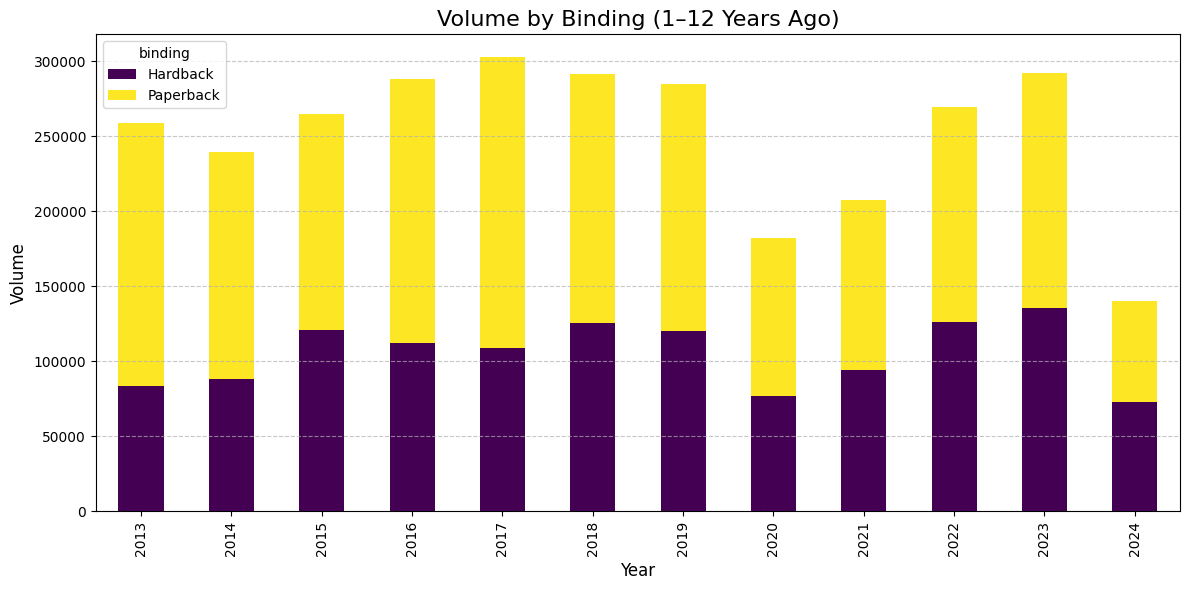

In [ ]:
df_chart = filtered_df.copy()

df_chart['year'] = df_chart['end_date'].dt.year

df_chart = df_chart[df_chart['year'] != 2001]   #### filtering out 2001 from charts as the very popular isbn skews charts visuals and results

def plot_stacked_bar(df, group_col, title):
    aggregated_data = df.groupby(['year', group_col])['volume'].sum().reset_index()

    pivot_data = aggregated_data.pivot_table(index='year', columns=group_col, values='volume', fill_value=0)
    pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

    plt.title(title, fontsize=16)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Volume", fontsize=12)
    plt.legend(title=group_col, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()

# Splitting the data into two periods
current_year = pd.Timestamp.now().year
period_12_24_years_ago = df_chart[(df_chart['year'] >= current_year - 24) & (filtered_df['year'] < current_year - 12)]
period_1_12_years_ago = df_chart[(df_chart['year'] >= current_year - 12) & (filtered_df['year'] <= current_year)]

data_by_type = [
    ("publisher_group", period_12_24_years_ago, "Volume by Publisher Group (12–24 Years Ago)"),
    ("publisher_group", period_1_12_years_ago, "Volume by Publisher Group (1–12 Years Ago)"),
    ("binding", period_12_24_years_ago, "Volume by Binding (12–24 Years Ago)"),
    ("binding", period_1_12_years_ago, "Volume by Binding (1–12 Years Ago)")
]

for group_col, data, title in data_by_type:
    plot_stacked_bar(data, group_col, title)

There are clear interesting trends that stand out from the data when looking at sales by **Publisher Group** and binding type by year.

The data shows that some Publishers (for example Walker Group) gained more popularity in the more recent years (1-12 period) with an almost steady growth. This could be due to the release of multiple pubblications or possibly to the growing popularity gained over time, or new trendy content. Other publisher have lost some momentum over time, with a slow downtrend (those represented by darker color shades bars).

Overall the data clearly establish important key trends in the more recent years for upcoming and growing Publishers.

With regards to **binding** type, hardback books have become more popular in proportion compared to the previous period, and this could be to the consumer preferences and product perception: for example for their durability and premium feel, gift appeal, displayability and aesthetic appeal, book collecting trends.

# Part 2: Deep Dive into Selected Books and Classical Techniques

The modeling work will focus on two key books that have displayed a positive trend in the most recent sales: "*The Alchemist*" and "*The Hungry Caterpillar*".

###*'The Alchemist' and 'The Hungry Caterpillar' data*

In [ ]:
# Filter the Data
isbn_selection = df_trend[df_trend['title'].str.contains("Hungry Caterpillar|Alchemist", case=False, na=False)]
distinct_isbn_title = isbn_selection [['isbn', 'title']].drop_duplicates()
print(distinct_isbn_title)

                     isbn                         title
end_date                                               
2001-01-06  9780241003008  Very Hungry Caterpillar, The
2001-01-06  9780722532935                Alchemist, The
2001-01-06  9780140500875  Very Hungry Caterpillar, The


There are two isbns for Very Hungry Caterpillar, however one of them only has a total volume sale of 2 (9780140500875). I will remove this from the analysis.

In [ ]:
# In this part I extract a few details about the chosen books
df_trend_copy = df_trend.copy()

def get_unique_info_by_isbn(df, isbn):
    df_trend_copy = df[df['isbn'] == isbn]

    if not df_trend_copy.empty:
        unique_title = df_trend_copy['title'].unique()
        unique_publisher_group = df_trend_copy['publisher_group'].unique()
        unique_binding = df_trend_copy['binding'].unique()
        unique_product_class = df_trend_copy['product_class'].unique()

        print(f"\nUnique information for ISBN {isbn}:")
        print(f"Titles: {', '.join(unique_title)}")
        print(f"Publisher Groups: {', '.join(unique_publisher_group)}")
        print(f"Bindings: {', '.join(unique_binding)}")
        print(f"Product Classes: {', '.join(unique_product_class)}")
    else:
        print(f"No data found for ISBN {isbn}")

isbn1 = '9780722532935'
isbn2 = '9780241003008'

get_unique_info_by_isbn(df_trend, isbn1)
get_unique_info_by_isbn(df_trend, isbn2)


Unique information for ISBN 9780722532935:
Titles: Alchemist, The
Publisher Groups: HarperCollins Grp
Bindings: Paperback
Product Classes: F1.1 General & Literary Fiction

Unique information for ISBN 9780241003008:
Titles: Very Hungry Caterpillar, The
Publisher Groups: Penguin Grp
Bindings: Hardback
Product Classes: Y1.3 Picture Books


Time Series data is displayed for 2012 onwards results.

The Alchemist DataFrame Shape: (656, 7)
The Very Hungry Caterpillar DataFrame Shape: (656, 7)
ISBNs for The Alchemist: ['9780722532935']
ISBNs for The Very Hungry Caterpillar: ['9780241003008']


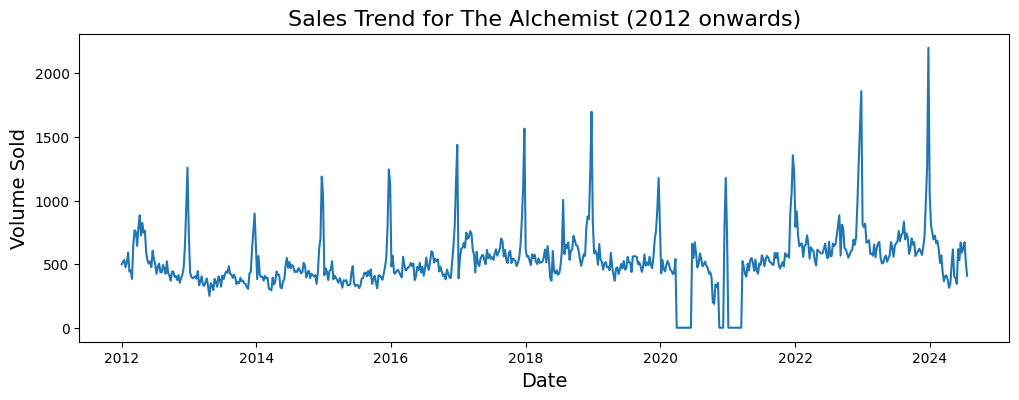

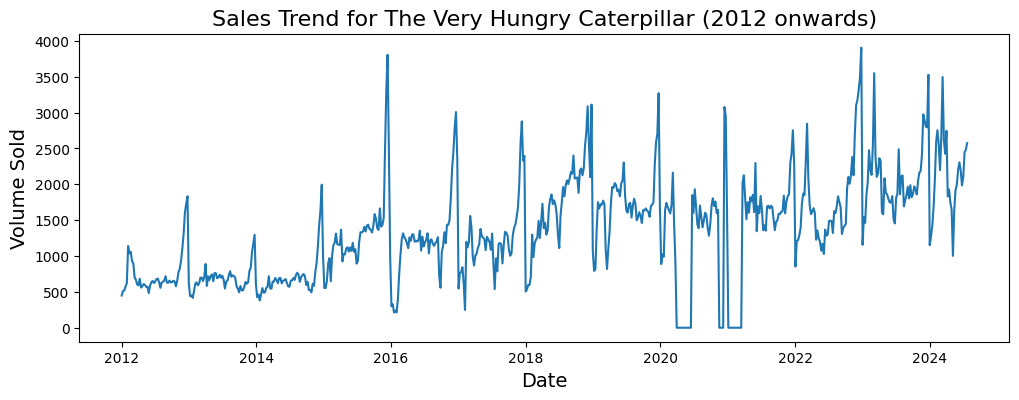

In [ ]:
df_alchemist = filtered_df[
    (filtered_df['isbn'].str.contains('9780722532935', case=False, na=False)) &
    (filtered_df['end_date'].dt.year >= 2012)
]

df_hungry_caterp = filtered_df[
    (filtered_df['isbn'].str.contains('9780241003008', case=False, na=False)) &
    (filtered_df['end_date'].dt.year >= 2012)
]

print("The Alchemist DataFrame Shape:", df_alchemist.shape)
print("The Very Hungry Caterpillar DataFrame Shape:", df_hungry_caterp.shape)

alchemist_isbn = df_alchemist['isbn'].unique()
print("ISBNs for The Alchemist:", alchemist_isbn)

caterpillar_isbn = df_hungry_caterp['isbn'].unique()
print("ISBNs for The Very Hungry Caterpillar:", caterpillar_isbn)

plt.figure(figsize=(12, 4))
sns.lineplot(x='end_date', y='volume', data=df_alchemist)
plt.title('Sales Trend for The Alchemist (2012 onwards)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume Sold', fontsize=14)
plt.show()

plt.figure(figsize=(12, 4))
sns.lineplot(x='end_date', y='volume', data=df_hungry_caterp)
plt.title('Sales Trend for The Very Hungry Caterpillar (2012 onwards)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume Sold', fontsize=14)
plt.show()

As per previous analysis on overall sales, there's a noticeable dip in sales around 2020. This could be related to the COVID-19 pandemic and associated lockdowns, which disrupted retail sales in many sectors. The data shows 0 sales during pandemic periods: I will keep this data as 0 due to its genuine nature reflecting real sales. These might require external factors accounting for i.e. COVID when modeling sales volumes.

***General Trends***

**The Alchemist:** The sales trend shows some fluctuations but appears to be relatively stable with a slight, constant, upward trend from 2020 onwards.

**The Very Hungry Caterpillar:** The sales trend also shows fluctuations but appears to have a more pronounced upward trend from 2020 onwards, suggesting that the book's popularity has been increasing in recent years.



Both charts might exhibit seasonal patterns, with higher sales during certain times of the year, such as holiday seasons (Christmas, Easter) or back-to-school periods.


###**1.** Performing decomposition on the data for both books.

Since there are some spikes and outliers in the data (with a few 0 values in certain periods) I now use a more flexible decomposition technique: **Seasonal-Trend Decomposition Procedure Based on Loess (STL)**. This technique can handle a wider range of seasonal patterns and the model controls the smoothness of the trend and is robust to outliers.

**The Alchemist**

In [ ]:
# Resampling the data to weekly frequency
df_alchemist_resampled = df_alchemist.set_index('end_date').resample('W').agg({'volume': 'sum'}).fillna(0)

In [ ]:
# Performing STL decomposition and extracting data components (trend, seasonality, residuals)
stl = STL(df_alchemist_resampled['volume'], period=52, seasonal=7, trend=None)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

In [ ]:
# Calculating variances and strengths
var_original = np.var(df_alchemist_resampled['volume'], ddof=1)
var_residual = np.var(residual, ddof=1)
var_trend = np.var(trend, ddof=1)

trend_strength = 1 - (var_residual / var_original)
seasonality_strength = 1 - ((var_residual + var_trend) / var_original)

Trend Strength: 0.8405551620776532
Seasonality Strength: 0.6278810250024147


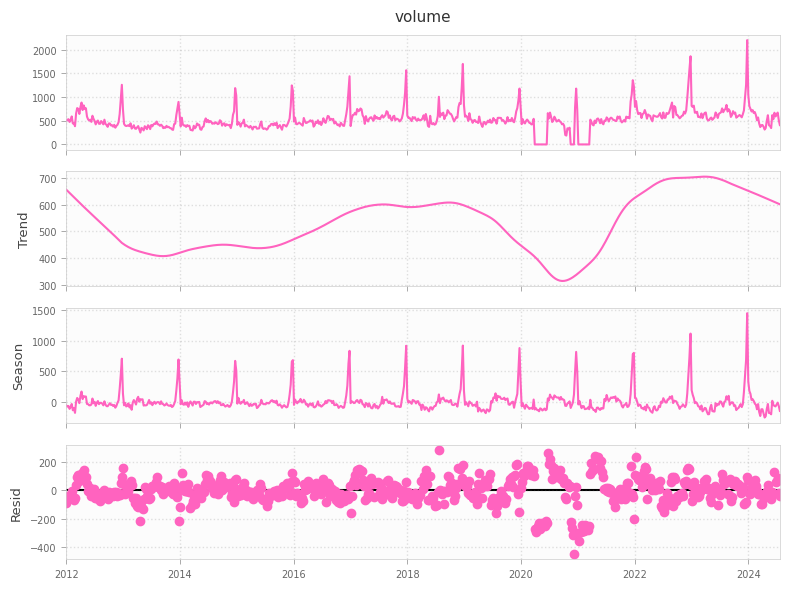

In [ ]:
print("Trend Strength:", trend_strength)
print("Seasonality Strength:", seasonality_strength)

import matplotlib.pyplot as plt
result.plot()
plt.show()

Looking at the components in the decomposition plot for "The Alchemist":

**Original Series (Top Panel):**

The original time series displays clear seasonal patterns with sharp peaks that repeat annually.
There is also a gradual long-term change in the baseline, indicating an overall trend in the data.

**Trend Component (Second Panel):**

The trend shows a smooth, long-term upward and downward movement in the data.
There appears to be an increasing trend from 2012 to around 2020, followed by a decline (due to pandemic) and another upward trend after 2021.

**Seasonal Component (Third Panel):**

The seasonal component reveals strong, consistent peaks and troughs across the years.
The pattern is highly regular, reflecting a stable seasonal effect with a periodicity of 52 weeks (e.g., weekly data with annual seasonality), this is reflected around Christmas time.

**Residual Component (Bottom Panel):**

The residuals are scattered around zero and appear to capture the irregular fluctuations in the data that are not explained by the trend or seasonal components.
There are no obvious patterns in the residuals, suggesting that the decomposition effectively isolates the trend and seasonal components.

**Key Insights**

**Trend Strength (0.84)**: The trend component explains a significant portion of the variability in the data. This indicates a strong, underlying long-term signal.
**Seasonality Strength (0.63)**: The seasonal component also contributes substantially to the overall variability, though less so than the trend.

The **residuals**, while noisy, appear relatively small in magnitude, further supporting the effectiveness of the decomposition.

**The Hungry Caterpillar**

In [ ]:
# Resampling the data to weekly frequency
df_hungry_caterp_resampled = df_hungry_caterp.set_index('end_date').resample('W').agg({'volume': 'sum'}).fillna(0)

In [ ]:
# Performing STL decomposition and extracting data components (trend, seasonality, residuals)
stl = STL(df_hungry_caterp_resampled['volume'], period=52, seasonal=7, trend=None)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

In [ ]:
# Calculating variances and strengths
var_original = np.var(df_hungry_caterp_resampled['volume'], ddof=1)
var_residual = np.var(residual, ddof=1)
var_trend = np.var(trend, ddof=1)

trend_strength = 1 - (var_residual / var_original)
seasonality_strength = 1 - ((var_residual + var_trend) / var_original)

Trend Strength: 0.7909276279851087
Seasonality Strength: 0.35723884890971824


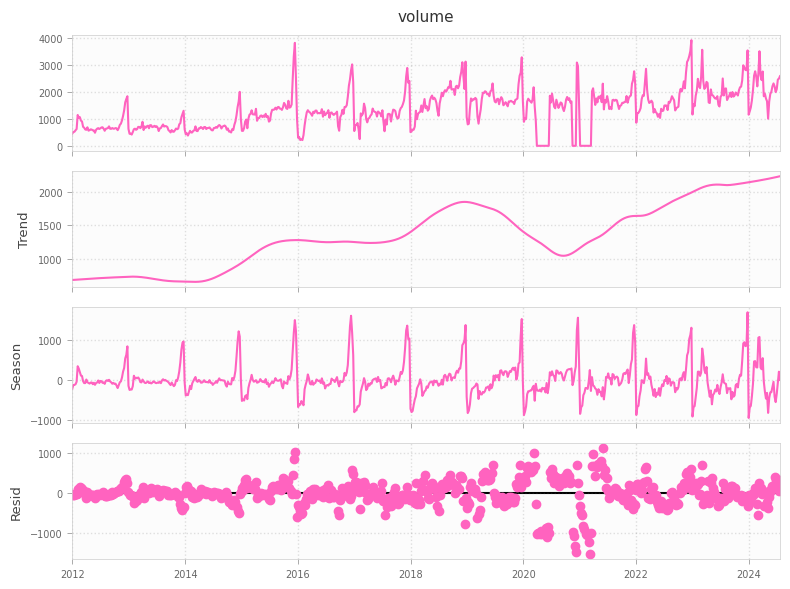

In [ ]:
print("Trend Strength:", trend_strength)
print("Seasonality Strength:", seasonality_strength)

import matplotlib.pyplot as plt
result.plot()
plt.show()

Looking at the components in the decomposition plot for "The Hungry Caterpillar":

**Trend Component (Second Panel):**

 The trend component shows a gradual upward slope, indicating a general increase in volume over the period. This could be due to various factors such as increasing popularity, effective marketing strategies, or a growing customer base.

**Seasonal Component (Third Panel):**

 The seasonality component exhibits fluctuations that repeat periodically. This could be due to factors like holidays, promotions, or other recurring events like Christmas period. The moderate seasonality strength suggests that these seasonal patterns are present but not as pronounced as the overall trend.

**Residual Component (Bottom Panel):**

 The residuals plot shows the remaining component after removing the trend and seasonality. Ideally, the residuals should be random and white noise (no discernible patterns). However, the plot suggests some patterns or autocorrelation might still be present in the residuals.


***Key insights***

The results indicates a high **trend strength (0.79)**, suggesting a strong underlying upward or downward trend in the data.

The **seasonality strength (0.35)** is moderate, indicating that seasonal patterns are present but not as dominant as the trend.

**Residual Analysis**: The presence of patterns in the residuals suggests that the decomposition might not have fully captured all the underlying patterns in the data. Further analysis and model refinement might be necessary.


###**2.** Performing ACF and PACF on both books.


 The Alchemist 


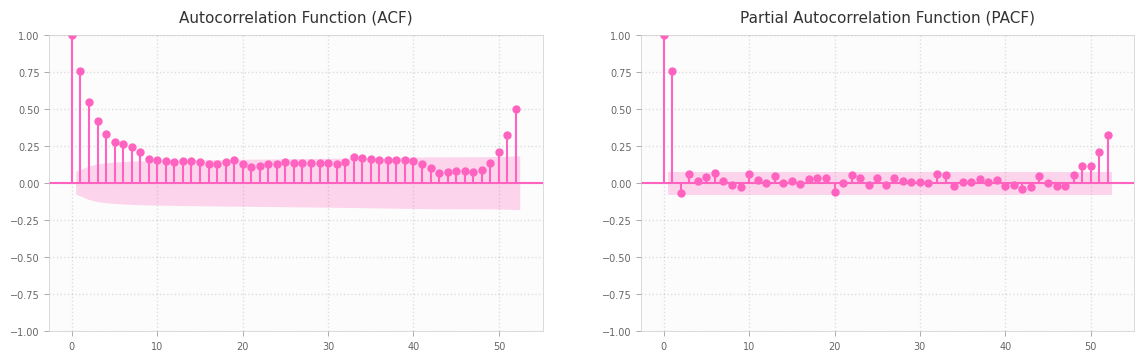


 The Very Hungry Caterpillar 


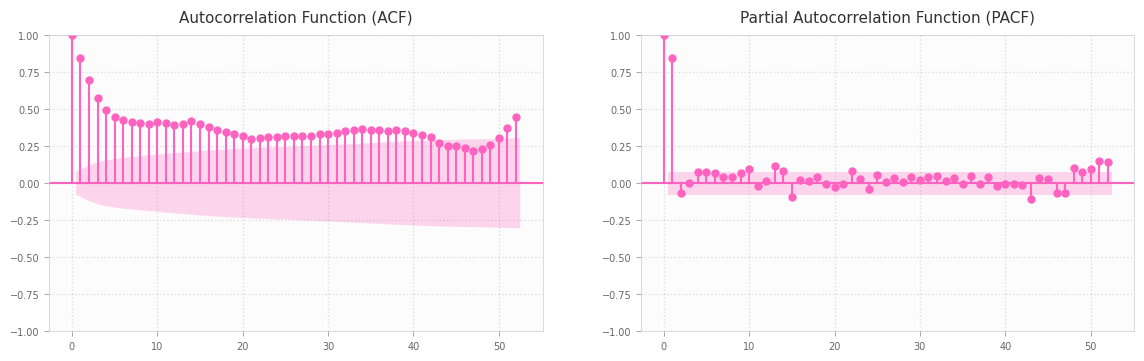

In [ ]:
# Plotting ACF and PACF
def plot_acf_pacf(df):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    plot_acf(df['volume'], lags=52, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    plot_pacf(df['volume'], lags=52, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.show()

# --- The Alchemist ---
print("\n The Alchemist ")
plot_acf_pacf(df_alchemist_resampled)

# --- The Very Hungry Caterpillar ---
print("\n The Very Hungry Caterpillar ")
plot_acf_pacf(df_hungry_caterp_resampled)

The ACF plots for both books show a strong initial lag (close to 1) that gradually decreases over time, indicating that past sales have a significant influence on current sales. This pattern is typical of non-stationary data.
The slow decay suggests the presence of trend or seasonality.

The PACF shows a significant spike at lag 1 for both books, followed by much smaller or no significant spikes at higher lags. This indicates that a simple autoregressive (AR) process of order 1 might explain much of the dependency structure in the data.
Additional minor spikes at specific higher lags could point to underlying seasonal patterns or residual correlations in the data.

**Key Insights:**
Both time series exhibit similar characteristics, with strong autocorrelations at lower lags and diminishing effects at higher lags.
The significant initial spike in the PACF suggests an AR(1) process might be a good starting point for modeling.
The slow decay in ACF could indicate the need for differencing to make the data stationary.


Using the ACF and PACF plots to gain insights for setting up ARIMA model parameters for "The Alchemist" and "The Very Hungry Caterpillar."

**The Alchemist**

*ACF:*
Significant spikes at the initial lags, followed by a gradual decay. This suggests a strong autoregressive component (AR) in the model.

*PACF:*
A few significant spikes at the initial lags, then trails off. This supports the presence of an AR component and suggests that a relatively low order AR model might be suitable.

**The Very Hungry Caterpillar**

*ACF:*
Significant spikes at multiple lags, indicating strong autocorrelation.

*PACF:*
A few significant spikes at the initial lags, then trails off. Similar to "The Alchemist," this suggests an AR component and a relatively low order AR model.

By running the stationarity test I am able to establish wether it is stationary or non-stationary data.


###**3.** Checking for stationarity.

**ADF**

In [ ]:
# Function to perform ADF test and print results
def adf_test(df):
    result = adfuller(df['volume'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    if result[1] <= 0.05:
        print("Conclusion: The time series is stationary.")
    else:
        print("Conclusion: The time series is non-stationary.")

# --- The Alchemist ---
print("\n The Alchemist ")
adf_test(df_alchemist_resampled)

# --- The Very Hungry Caterpillar ---
print("\n The Very Hungry Caterpillar ")
adf_test(df_hungry_caterp_resampled)


 The Alchemist 
ADF Statistic: -8.300549890381564
p-value: 4.029390006505253e-13
Critical Values:
   1%: -3.4404038931945276
   5%: -2.865976260062519
   10%: -2.5691324834372633
Conclusion: The time series is stationary.

 The Very Hungry Caterpillar 
ADF Statistic: -3.0330974291664927
p-value: 0.03191700254991505
Critical Values:
   1%: -3.4405928713433735
   5%: -2.866059505075432
   10%: -2.5691768365293113
Conclusion: The time series is stationary.


**"The Alchemist"** ADF Test Results:

The p-value is exceedingly small, essentially close to zero, and well below the standard significance threshold of 0.05. This indicates strong evidence against the null hypothesis, which posits that the time series has a unit root. Conclusion: The time series for "The Alchemist" is stationary, meaning its statistical properties such as mean and variance do not change over time.

**"The Very Hungry Caterpillar"** ADF Test Results:

The p-value is below the significance level of 0.05. This provides sufficient evidence to reject the null hypothesis at the 5% and 10% significance levels, confirming that this time series is also stationary. Although the level of stationarity here is slightly less pronounced than for "The Alchemist," the data still meets the criteria for stationarity.

**Overall Results:**
Both time series—"The Alchemist" and "The Very Hungry Caterpillar"—are confirmed to be stationary based on the ADF test results. Stationarity is a critical requirement for ARIMA modeling because it ensures the consistency of model parameters over time. Since both time series are already stationary, there is no need to apply differencing transformations, simplifying the ARIMA modeling process. This result underscores the suitability of these datasets for time series analysis.

###**4.** Performing Auto ARIMA on both books.

Following the above exploratory data analysis, initial data decompositions and stationarity test results, I now apply Auto ARIMA model to generate predictions and forecasts for the two selected books.

**1.** Setting reasonable bounds for the parameters based on the ACF/PACF analysis and stationarity test results.

**2.** Training the best-performing model on the training data (The training data will be from 2012-01-01 up to 32 weeks before the end of the dataset).

**3.** Utilising the trained model to generate forecasts for the next 32 weeks.



--- The Alchemist ---
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=7195.114, Time=2.60 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=7071.763, Time=11.55 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=7046.002, Time=23.11 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=7162.877, Time=1.60 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=7042.444, Time=35.93 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=7049.780, Time=11.35 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=7104.717, Time=31.00 sec
 ARIMA(1,1,1)(1,1,1)[52]             : AIC=7032.359, Time=56.50 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=7034.729, Time=43.66 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=7039.751, Time=17.47 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=7143.492, Time=3.88 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=7067.242, Time=41.50 sec
 ARIMA(1,1,1)(1,1,1)[52] intercept   : AIC=7034.344, Time=99.90 sec

Best model:  ARIMA(1,1,1)(1,1,1)[52]          
Total

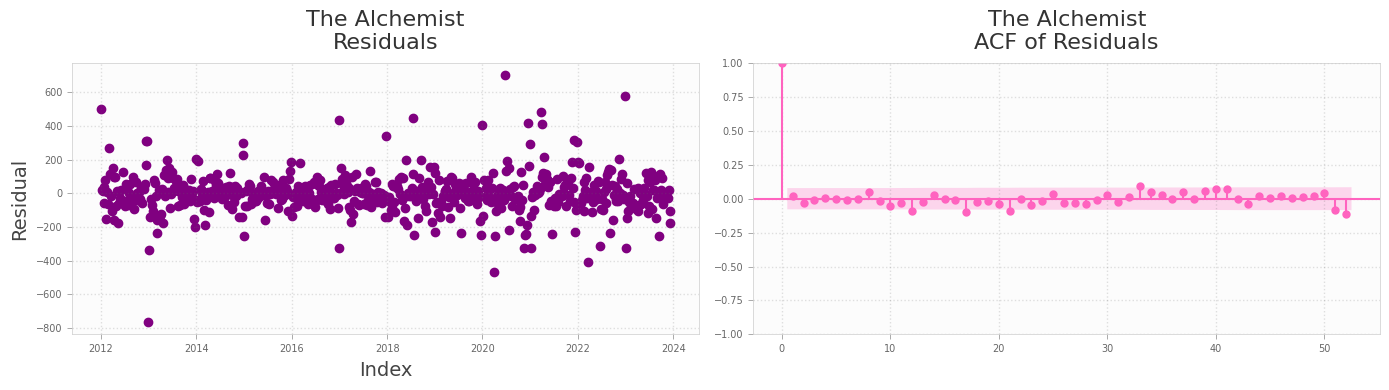

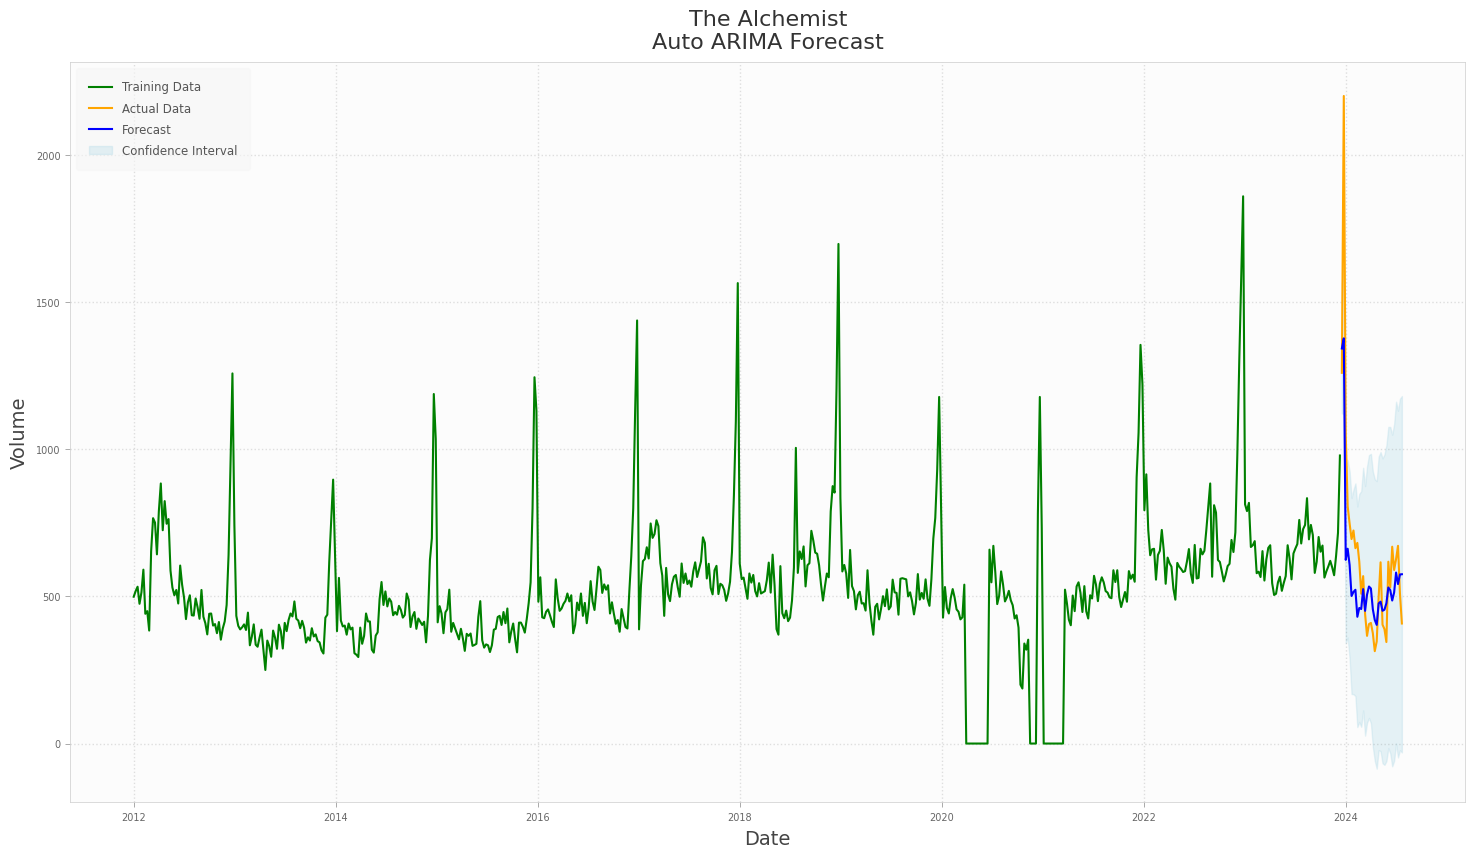


Mean Absolute Error (MAE): 139.68
Mean Absolute Percentage Error (MAPE): 21.30%
Forecast Accuracy: 78.70%

--- The Very Hungry Caterpillar ---
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=8510.250, Time=2.66 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=8390.071, Time=13.51 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=33.47 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=8509.382, Time=0.64 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=45.04 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=31.75 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=8391.600, Time=9.76 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=inf, Time=43.73 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=8389.104, Time=16.55 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=8508.817, Time=1.89 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=73.18 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=8391.102, Time=38.04 sec

Best model:  ARIMA(0,1,1)

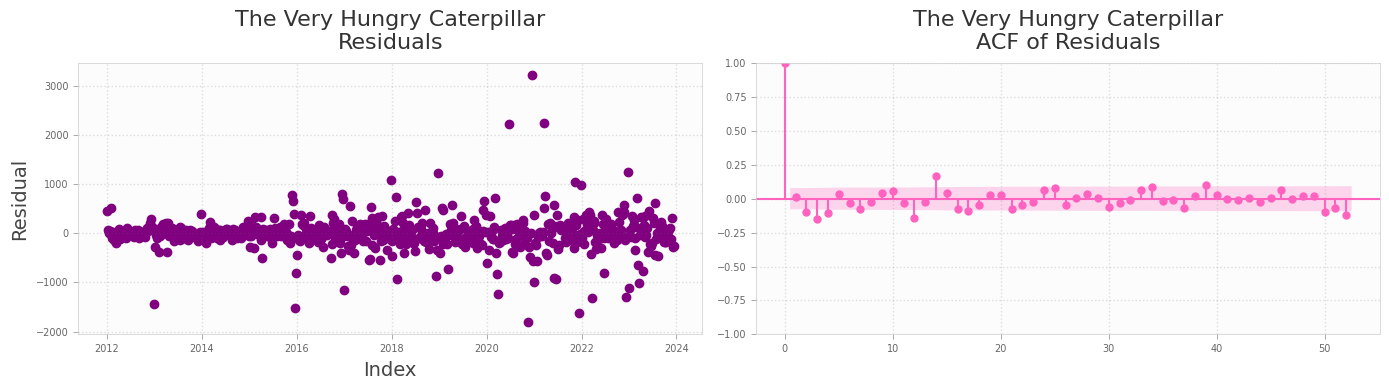

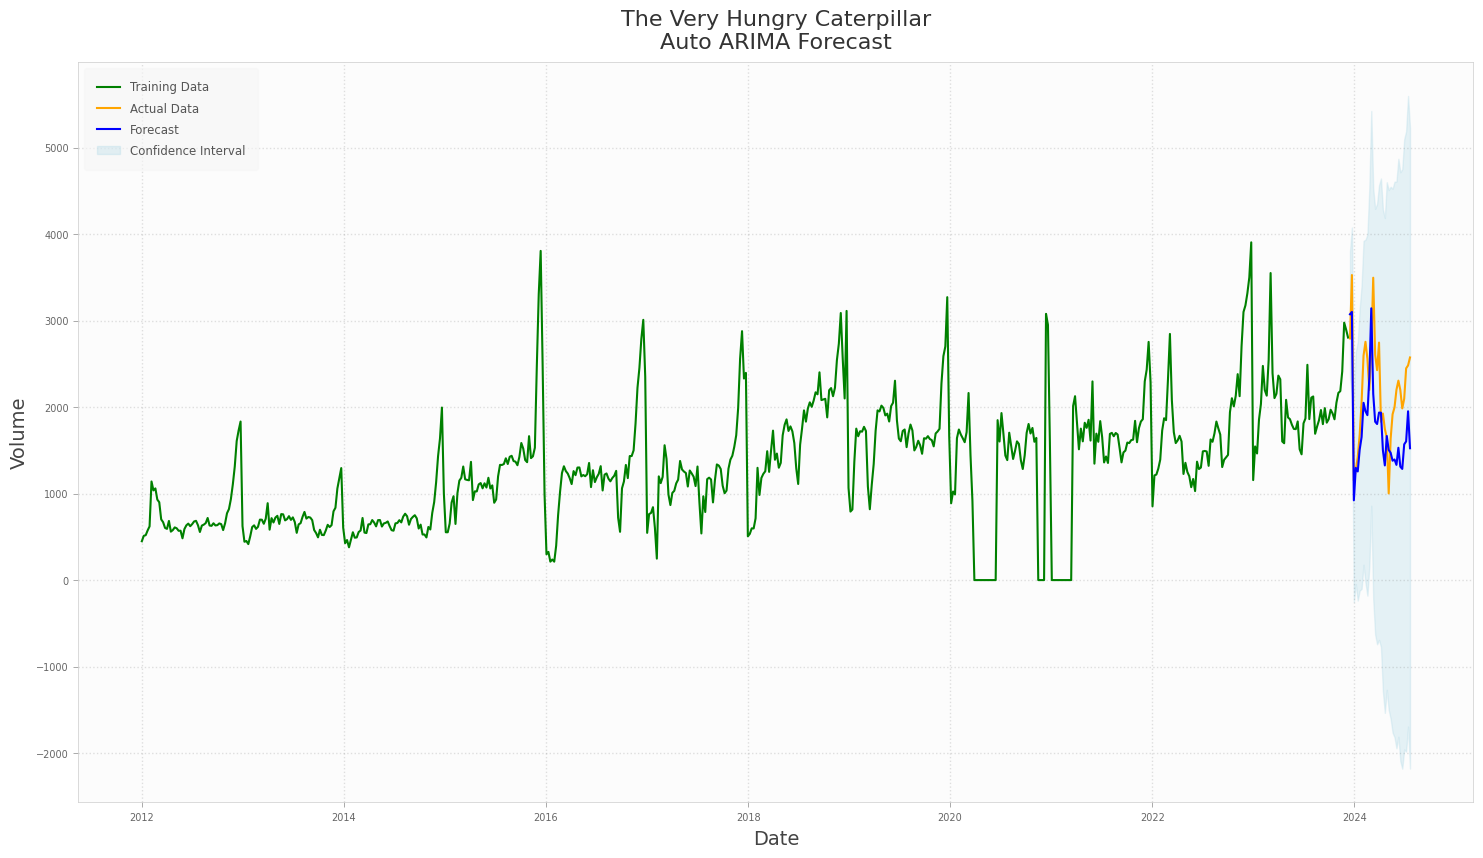


Mean Absolute Error (MAE): 525.80
Mean Absolute Percentage Error (MAPE): 23.45%
Forecast Accuracy: 76.55%


In [ ]:
## Defining function
def perform_auto_arima(df, title, file_name, max_p=1, max_q=1, max_P=1, max_Q=1, D=1):
    """
    Perform Auto ARIMA, analyze residuals, and make predictions.
    """
    # Here I split the data into train and test sets (final 32 weeks for testing)
    train_data = df['volume'][:-32]
    test_data = df['volume'][-32:]

# Fitting Auto ARIMA
    model = auto_arima(
        train_data,
        seasonal=True,
        m=52,  # Seasonal period (52 weeks)
        start_p=0,
        max_p=max_p,
        start_q=0,
        max_q=max_q,
        start_P=0,
        max_P=max_P,
        start_Q=0,
        max_Q=max_Q,
        d=1,  # Use differencing despite it's not required. This is to slightly improve the data.
        D=D,  # Seasonal differencing
        information_criterion='aic',
        stepwise=True,
        suppress_warnings=True,
        trace=True,
    )

    print(f"\nBest Model for {title}: {model.order} x {model.seasonal_order}")

    # Saving the model
    with open(file_name, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model for {title} saved as {file_name}")

    # Residual Analysis
    residuals = model.resid()
    print("\nResiduals Summary:")
    print(pd.Series(residuals).describe())

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    axes[0].scatter(residuals.index, residuals, color='purple')
    axes[0].set_title(f'{title}\nResiduals', fontsize=16)
    axes[0].set_xlabel('Index', fontsize=14)
    axes[0].set_ylabel('Residual', fontsize=14)

    plot_acf(residuals, lags=52, ax=axes[1])
    axes[1].set_title(f'{title}\nACF of Residuals', fontsize=16)
    plt.tight_layout()
    plt.show()

# Forecasting
    # Forecast the next 32 weeks
    forecast, conf_int = model.predict(n_periods=32, return_conf_int=True)

    # Create a DataFrame for forecast
    forecast_index = pd.date_range(start=train_data.index[-1], periods=33, freq='W')[1:]
    forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)
    conf_int_df = pd.DataFrame(conf_int, index=forecast_index, columns=['Lower CI', 'Upper CI'])

    plt.figure(figsize=(18, 10))
    plt.plot(train_data, label='Training Data', color='green')
    plt.plot(test_data, label='Actual Data', color='orange')
    plt.plot(forecast_df['Forecast'], label='Forecast', color='blue')
    plt.fill_between(forecast_index, conf_int_df['Lower CI'], conf_int_df['Upper CI'],
                     color='lightblue', alpha=0.3, label='Confidence Interval')
    plt.title(f'{title}\nAuto ARIMA Forecast', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Volume', fontsize=14)
    plt.legend()
    plt.show()

# Evaluation results
    mae = np.mean(np.abs(test_data.values - forecast))
    mape = np.mean(np.abs((test_data.values - forecast) / test_data.values)) * 100

    print(f"\nMean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Forecast Accuracy: {100 - mape:.2f}%")
    return model, forecast_df, conf_int_df


# Extracts for the two books
# book 1
print("\n--- The Alchemist ---")
model_alchemist, forecast_alchemist, conf_int_alchemist = perform_auto_arima(
    df_alchemist_resampled,
    "The Alchemist",
    "model_alchemist.pkl"
)

#book 2
print("\n--- The Very Hungry Caterpillar ---")
model_caterpillar, forecast_caterpillar, conf_int_caterpillar = perform_auto_arima(
    df_hungry_caterp_resampled,
    "The Very Hungry Caterpillar",
    "model_caterpillar.pkl"
)

***The Alchemist***

**Mean Absolute Error (MAE): 139.68**

The average absolute error of the forecast is 139. On average, the forecast deviates from the actual sales by 139.68 units.

**Mean Absolute Percentage Error (MAPE): 21.30%**

On average, the forecast is off by 21.30% compared to the actual sales.

**Forecast Accuracy: 78.70%**

It suggests that the model's predictions are accurate within 21.30% of the actual sales 78.70% of the time.

**Overall:**

The forecast accuracy of 78.70% suggests that the model provides a reasonable level of accuracy.

***The Very Hungry Caterpillar***

**Mean Absolute Error (MAE): 525.80**

The average absolute error of the forecast is 525.80.On average, the forecast deviates from the actual sales by 525.80 units.

**Mean Absolute Percentage Error (MAPE): 23.45%**

On average, the forecast is off by 23.45% compared to the actual sales.

**Forecast Accuracy: 76.55%**

It suggests that the model's predictions are accurate within 21.30% of the actual sales 76.55% of the time.

**Overall:**

The forecast accuracy of 76.55% suggests that the model provides a reasonable level of accuracy.

**Residuals distribution**

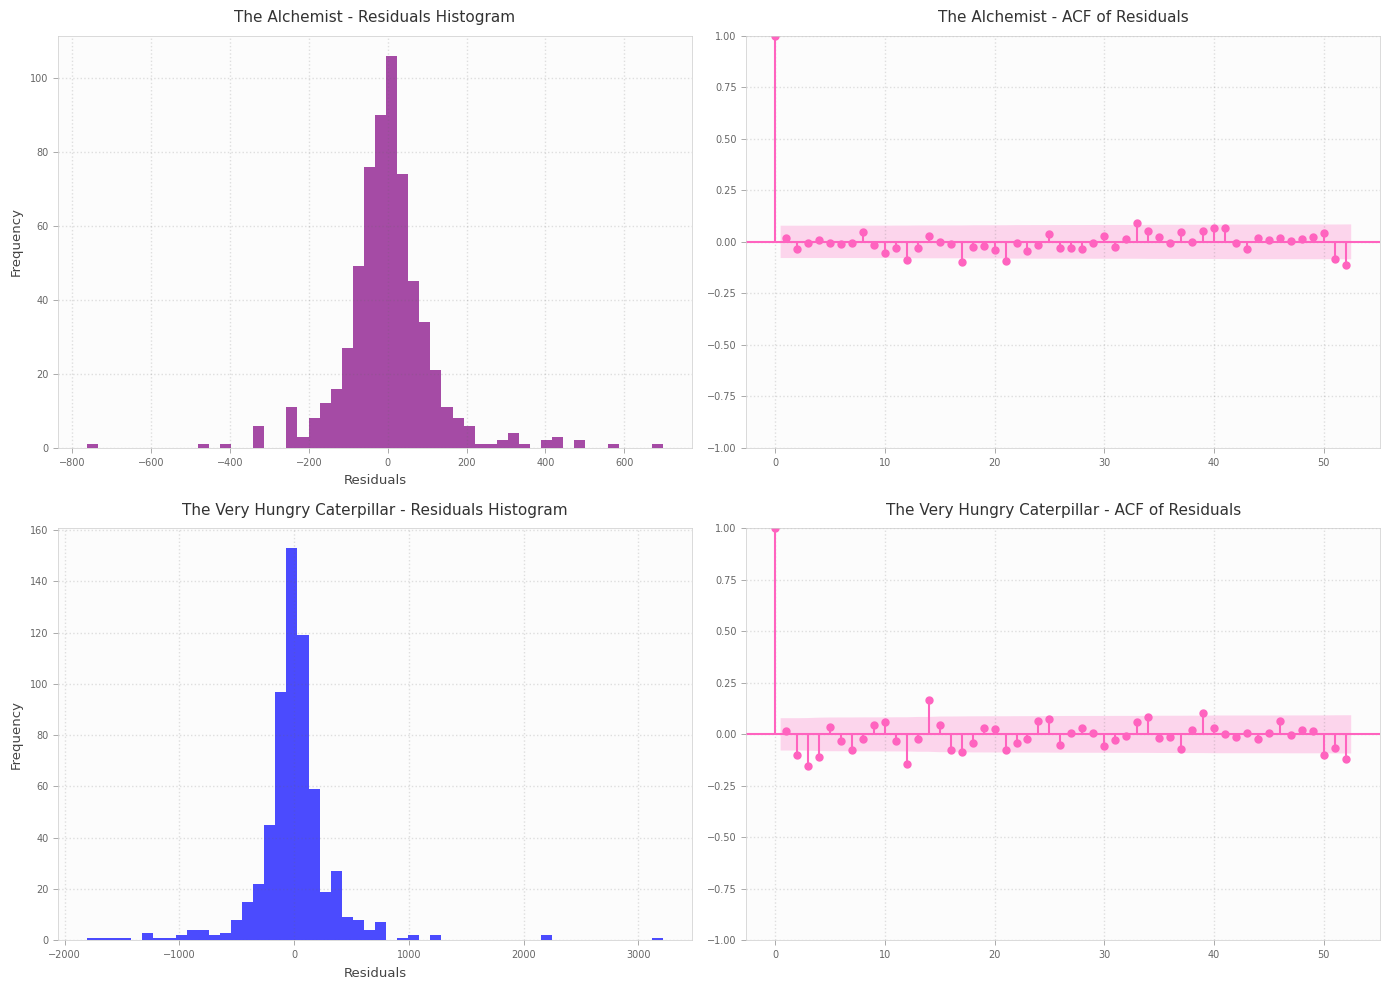

In [ ]:
residuals = {
    "The Alchemist": model_alchemist.resid() if callable(model_alchemist.resid) else model_alchemist.resid,
    "The Very Hungry Caterpillar": model_caterpillar.resid() if callable(model_caterpillar.resid) else model_caterpillar.resid
}

# Plotting residual histograms and ACF
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, (title, resid) in enumerate(residuals.items()):
    axes[i, 0].hist(resid, bins=52, color='purple' if i == 0 else 'blue', alpha=0.7)
    axes[i, 0].set_title(f"{title} - Residuals Histogram")
    axes[i, 0].set_xlabel("Residuals")
    axes[i, 0].set_ylabel("Frequency")

    plot_acf(resid, lags=52, ax=axes[i, 1])
    axes[i, 1].set_title(f"{title} - ACF of Residuals")

plt.tight_layout()
plt.show()


**Residuals analysis:**

Both histograms appear roughly symmetric, which is a good sign. Significant skewness would suggest potential issues with the model's assumptions.
The centers of both histograms are close to zero, indicating that the model's predictions are on average accurate.
Spread: The spread of residuals in "*The Very Hungry Caterpillar*" seems larger than that of "*The Alchemist*". This might suggest higher variability in the former's data or potentially less accurate predictions.

**ACF (Autocorrelation Function) Plots:**

*The Alchemist:* The ACF plot shows that the residuals are mostly within the confidence bands (shaded area). This indicates that there is little autocorrelation (correlation between residuals at different time points). This is generally desirable as it suggests the model has captured the temporal dependencies in the data.

*The Very Hungry Caterpillar:* The ACF plot shows some spikes outside the confidence bands (although not too far from the confidence bands). This suggests potential autocorrelation in the residuals, which could indicate that the model has not fully captured the temporal patterns in the data.


*The Alchemist:* The residuals histogram and ACF plot suggest that the model is performing well. The residuals are centered around zero, have a reasonable spread, and show little autocorrelation.

*The Very Hungry Caterpillar:* The larger spread in the residuals histogram and the presence of autocorrelation in the ACF plot indicate potential areas for improvement in the model. It might be necessary to explore different model structures or include additional features to capture the temporal dependencies more effectively.

###**Model's summary**

Printing out models' summaries details.

In [ ]:
# For 'The Alchemist'
print("\n--- The Alchemist Model Summary ---")
print(model_alchemist.summary())

# For 'The Very Hungry Caterpillar'
print("\n--- The Very Hungry Caterpillar Model Summary ---")
print(model_caterpillar.summary())


--- The Alchemist Model Summary ---
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  624
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -3511.180
Date:                            Thu, 16 Jan 2025   AIC                           7032.359
Time:                                    15:23:55   BIC                           7054.096
Sample:                                01-01-2012   HQIC                          7040.839
                                     - 12-10-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3302      0.069      4.789      0.000       0.195       0.46

***The Alchemist***

SARIMAX(1, 1, 1)x(1, 1, 1, 52): This indicates that the model is a Seasonal Autoregressive Integrated Moving Average model.

**Coefficients:**

*P-values:* All coefficients (ar.L1, ma.L1, ar.S.L52, ma.S.L52) have very low p-values (less than 0.05), indicating that they are statistically significant. This suggests that these terms are important for modeling the time series.

**Diagnostic Tests:**

*Ljung-Box Test:* Low value (0.00), suggesting that there might be some residual autocorrelation. This indicates that the model might not fully capture all the dependencies in the data.

*Heteroskedasticity Test:* Low p-value (0.00), suggesting unequal variances in the residuals. This might also indicate that the model could be improved by considering transformations or alternative models.

**Overall:**

The model captures some of the key dynamics in the "The Alchemist" sales data. However, the diagnostic tests suggest that there might be room for improvement in terms of capturing residual autocorrelation and addressing the non-normality and heteroscedasticity of the residuals.



***The Very Hungry Caterpillar***

SARIMAX(0, 1, 1)x(1, 1, 1, 52): This indicates that the model is a Seasonal Autoregressive Integrated Moving Average model.

**Coefficients:**

*P-values:* Both coefficients (ma.L1 and ar.S.L52) have very low p-values (less than 0.05), indicating that they are statistically significant. This suggests that these terms are important for modeling the time series.

**Diagnostic Tests:**

*Ljung-Box Test:* Low p-value (0.07), suggesting that there might be some residual autocorrelation. This indicates that the model might not fully capture all the dependencies in the data.

*Heteroskedasticity Test:* Low p-value (0.00), suggesting unequal variances in the residuals. This might also indicate that the model could be improved by considering transformations or alternative models.

**Overall:**

The model captures some of the key dynamics in "The Very Hungry Caterpillar" sales data. However, the diagnostic tests suggest that there might be room for improvement in terms of capturing residual autocorrelation and addressing the non-normality and heteroscedasticity of the residuals.

In the rest of the project I will apply different, more advanced, modelling techniques which might become relevant in improving forecasts and results.



# Part 3: Machine Learning and Deep Learning Techniques

###**1.** Feature Engineering: preparing data for XGBoost model.

Preparing data for an XGBoost time series model requires careful feature engineering:

**1. Lagged Features**
I will create lagged versions of the target variable to capture past dependencies

**2. Rolling Window Statistics**
I also add a rolling mean, standard deviation, min, and max to capture trends (the window_size in the feature engineering step creates new features, while the window_length in GridSearchCV (if used for rolling window forecasting) controls the size of the training window for the model at each step)

**3. Time-Based Features**

Creating lagged features to represent past observations as features for prediction

In [ ]:
## Defining data preparation function

def prepare_scaled_data_for_ml(df, lags=32, window_sizes=[4, 12, 52], test_size=32): ## 4 weeks for monthly, 12 weeks for quarterly and 52 weeks for yearly
                                                                                     ## setting test size to 32 weeks, for the forecast horizon (32 weeks)
                                                                                     ## lags=32 corresponds to the forecast horizon of 32 weeks, ensuring the model has sufficient historical context to predict the target values for the next 32 weeks.
# 1. Feature Engineering
    data = df.copy()
    if 'end_date' in data.columns:
        data.set_index('end_date', inplace=True)

    # Lagged features
    for i in range(1, lags + 1):
        data[f'Volume_lag{i}'] = data['volume'].shift(i)

    # Rolling window statistics
    for window_size in window_sizes:
        data[f'Volume_rolling_mean_{window_size}'] = data['volume'].rolling(window=window_size).mean()
        data[f'Volume_rolling_std_{window_size}'] = data['volume'].rolling(window=window_size).std()
        data[f'Volume_rolling_min_{window_size}'] = data['volume'].rolling(window=window_size).min()
        data[f'Volume_rolling_max_{window_size}'] = data['volume'].rolling(window=window_size).max()


    # Handle missing values produced from added features
    data.fillna(0, inplace=True)

# 2. Create X and target y
    target = 'volume'
    features = [col for col in data.columns if col != target]

    X = data[features]
    y = data[target]

# 3. Train/Test Split
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]

# 4. Normalising data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit.transform(X_test)


    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [ ]:
## Applying the function above to our datasets and generate datasets for modeling on both books

X_train_sc_a, X_test_sc_a, y_train_sc_a, y_test_sc_a, scaler_sc_a = prepare_scaled_data_for_ml(
    df_alchemist_resampled
)
X_train_sc_hc, X_test_sc_hc, y_train_sc_hc, y_test_sc_hc, scaler_sc_hc = prepare_scaled_data_for_ml(
    df_hungry_caterp_resampled
)

# Print shapes to verify
print("X_train_sc_a shape:", X_train_sc_a.shape)
print("X_test_sc_a shape:", X_test_sc_a.shape)
print("y_train_sc_a shape:", y_train_sc_a.shape)
print("y_test_sc_a shape:", y_test_sc_a.shape)
print("X_train_sc_hc shape:", X_train_sc_hc.shape)
print("X_test_sc_hc shape:", X_test_sc_hc.shape)
print("y_train_sc_hc shape:", y_train_sc_hc.shape)
print("y_test_sc_hc shape:", y_test_sc_hc.shape)

X_train_sc_a shape: (624, 47)
X_test_sc_a shape: (32, 47)
y_train_sc_a shape: (624,)
y_test_sc_a shape: (32,)
X_train_sc_hc shape: (624, 47)
X_test_sc_hc shape: (32, 47)
y_train_sc_hc shape: (624,)
y_test_sc_hc shape: (32,)


###**2.** Performing XGBoost on both books.

**1.** I implement here GridSearchCV to tune hyperparameters, specifically focusing on the optimal window length for incorporating historical data.

**2.** Generating cross-validation with hypeparameters and window length.

**3.** Training the best-performing model on the training data.

**4.** I then utilise the trained model to generate forecasts for the next 32 weeks.

**Defining relevant functions**

Window length

In [ ]:
def apply_window_length(X, window_length):
    """
    Applies a rolling window transformation to each feature in the dataset.
    Calculates rolling mean for each feature based on the specified window length.
    Drops rows with NaN values resulting from the rolling operation.

    """
    if isinstance(X, (np.ndarray, pd.Series)):
        X = pd.DataFrame(X)
    elif isinstance(X, pd.DataFrame) and X.shape[1] == 1:
        if isinstance(X.columns[0], int):
            X = X.rename(columns={X.columns[0]: str(X.columns[0])})

        X = X.rename(columns={X.columns[0]: 'feature'})

    X_window = X.copy()

    # Apply rolling mean to each column in the dataset
    for col in X.columns:
        col_name = str(col)
        if not col_name.endswith('_ma'):
            # Calculate rolling mean and add it as a new feature
            X_window[f'{col_name}_ma'] = X[col].rolling(window=window_length, min_periods=1).mean()

    X_window = X_window.dropna()

    return X_window

Hyperparameters grid

In [ ]:
def prepare_param_grid():
    return {
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 8],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.9, 1.0],
        'reg_alpha': [0, 0.1],  # L1 regularization
        'reg_lambda': [0, 0.1],  # L2 regularization
    }


Function to perform cross-validation with the hyperparameter grid and window_length

In [ ]:
def cross_validate(X_train_scaled, y_train, param_grid, window_length_values):
    best_params = None
    best_score = float('inf')

    # Iterate over each window_length value
    for window_length in window_length_values:
        X_train_window = apply_window_length(X_train_scaled, window_length)

        dtrain = xgb.DMatrix(X_train_window, label=y_train)

        # Perform cross-validation using xgb.cv
        for params in [dict(zip(param_grid, v)) for v in product(*param_grid.values())]:
            cv_results = xgb.cv(
                params,
                dtrain,
                num_boost_round=100,
                early_stopping_rounds=10,
                nfold=3,
                metrics='mae',
                as_pandas=True,
                seed=42,
                folds=list(TimeSeriesSplit(n_splits=3).split(X_train_window, y_train))
            )

            # Get the average MAE from the cross-validation results
            mean_mae = cv_results['test-mae-mean'].iloc[-1]

            # Updating best parameters if current configuration is better
            if mean_mae < best_score:
                best_score = mean_mae
                best_params = params
                best_window_length = window_length

    return best_params, best_window_length

Function to train the XGBoost model with the best hyperparameters

In [ ]:
def train_xgboost_model(X_train_scaled, y_train, best_params, best_window_length):
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)

    # Training the final model
    best_xgb_model = xgb.train(best_params, dtrain, num_boost_round=100)

    return best_xgb_model

Function to evaluate the trained model

In [ ]:
def evaluate_model(best_xgb_model, X_test_scaled, y_test, title):
    # Convert test data to DMatrix
    dtest = xgb.DMatrix(X_test_scaled)

    # Forecast on the test set
    y_pred = best_xgb_model.predict(dtest)

    # Calculate MAE and MAPE
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    return y_pred, mae, mape

In [ ]:
# Plotting the results with MAE and MAPE
def plot_results(X_train_scaled, y_train, y_test, y_pred, title, mae, mape):
    plt.figure(figsize=(20, 10))
    plt.plot(y_train.index, y_train, label='Training Data', color='green')
    plt.plot(y_test.index, y_test, label='Actual Data', color='orange')
    plt.plot(y_test.index, y_pred, label='Forecast', color='blue')

    mae_text = f"MAE: {mae:.2f}"
    mape_text = f"MAPE: {mape:.2f}%"

    plt.text(0.05, 0.95, mae_text, transform=plt.gca().transAxes, fontsize=12, color="black",
             bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray"))
    plt.text(0.05, 0.90, mape_text, transform=plt.gca().transAxes, fontsize=12, color="black",
             bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray"))

    plt.title(f'{title}\nXGBoost Forecast', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Volume Sold', fontsize=14)
    plt.legend(loc='upper right')
    plt.show()


Main function to train, evaluate, and plot the results

In [ ]:
def train_and_evaluate_xgboost(X_train_scaled, y_train, X_test_scaled, y_test, title):
    param_grid = prepare_param_grid()   # Preparing the hyperparameter grid

    window_length_values = [5, 10, 15]  # possible window lengths for feature engineering

    best_params, best_window_length = cross_validate(X_train_scaled, y_train, param_grid, window_length_values) # Performing cross-validation to find the best hyperparameters and window_length

    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Window Length: {best_window_length}")

    # Training the final XGBoost model using the best parameters and window_length
    X_train_window = apply_window_length(X_train_scaled, best_window_length) # Applying the best window_length feature engineering

    best_xgb_model = train_xgboost_model(X_train_window, y_train, best_params, best_window_length)  # Passing best_window_length

    # Model evaluation and results plotting
    X_test_window = apply_window_length(X_test_scaled, best_window_length)
    y_pred, mae, mape = evaluate_model(best_xgb_model, X_test_window, y_test, title)

    plot_results(X_train_scaled, y_train, y_test, y_pred, title, mae, mape)

    return best_xgb_model, mae, mape

**Training, validating and chosing the best models:**

***The Alchemist***

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_alpha': 0, 'reg_lambda': 0}
Best Window Length: 5
Mean Absolute Error (MAE): 115.21
Mean Absolute Percentage Error (MAPE): 0.16%


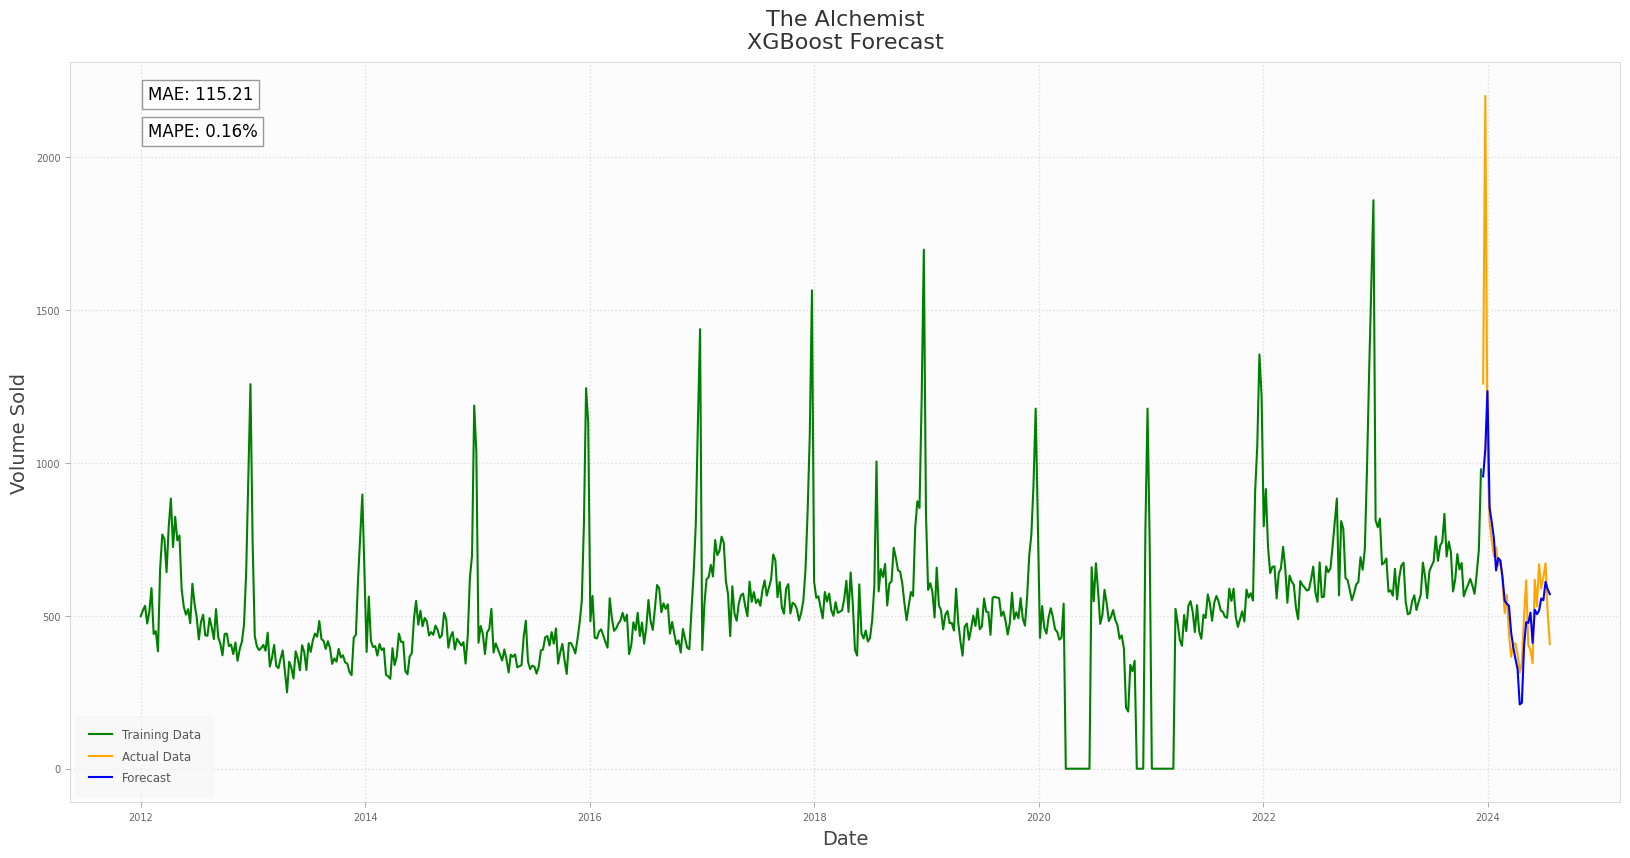

In [ ]:
# Train and evaluate for "The Alchemist"
best_xgb_model_alchemist, mape_alchemist, mae_alchemist = train_and_evaluate_xgboost(
    X_train_sc_a, y_train_sc_a, X_test_sc_a, y_test_sc_a, "The Alchemist"
)


***The Very Hungry Caterpillar***

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 0.9, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best Window Length: 15
Mean Absolute Error (MAE): 289.66
Mean Absolute Percentage Error (MAPE): 0.14%


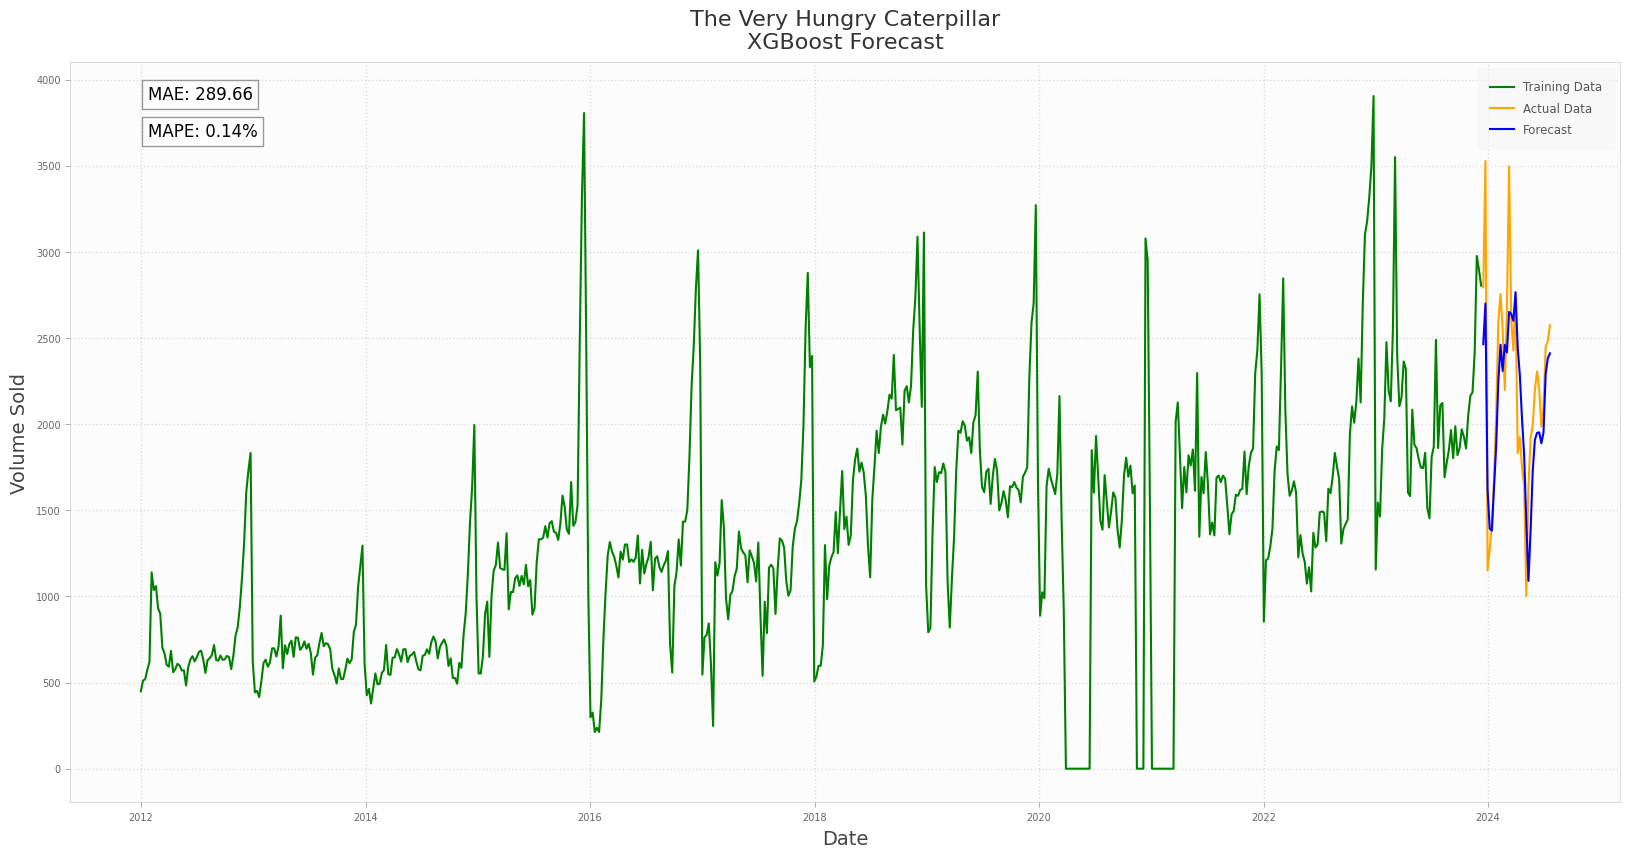

In [ ]:
# Train and evaluate for "The Very Hungry Caterpillar"
best_xgb_model_caterp, mape_caterp, mae_caterp = train_and_evaluate_xgboost(
    X_train_sc_hc, y_train_sc_hc, X_test_sc_hc, y_test_sc_hc, "The Very Hungry Caterpillar"
)


*The Alchemist*: Mean Absolute Error (MAE): 115.21 this indicates that, on average, the model's predictions deviate from the actual values by approximately 115.21 units. Mean Absolute Percentage Error (MAPE): 0.16%

*The Very Hungry Caterpillar*: the MAE of 289.66 shows that, on average, the model's predictions are off by about 290 units of sales volume from the actual values. Considering this represents only about 2.9% to 7.2% of the typical sales range, the error is quite small, indicating strong performance overall.
The MAPE of 0.14% means the model’s prediction error averages just 0.14% of the actual sales values, which is incredibly low. This highlights the model’s accuracy and its ability to make precise predictions, regardless of the scale of sales.

From what I’ve observed, the XGBoost model has effectively captured the overall trend and seasonality in the historical data. The forecast fairly closely aligns with the actual values, althought not caputring the more visible spikes.

The low MAE relative to the sales range and the remarkably low MAPE confirm that the model is both precise in absolute terms and highly accurate in relative terms. These performance metrics suggest that the model reliably captures the underlying patterns in the data and produces dependable forecasts.

With some fine-tuning of the parameters, there’s potential to push the model’s performance even further, especially to capture the more volatile data and spikes.

###**3.** Preparing data for LSTM.

The data preparation process for LSTM is similar to that for XGBoost, with some additional steps. In LSTM, both the features (X) and the target variable (y) are scaled to improve the model's training performance, since LSTM is sensitive to the scale of input data. After generating predictions, the scaled predictions are then inverse-transformed back to their original scale, allowing direct comparison with the actual values.

In [ ]:
def prepare_data_for_lstm(df, lags=32, window_sizes=[4, 12, 52], test_size=32):
    data = df.copy()
    if 'end_date' in data.columns:
        data.set_index('end_date', inplace=True)

    for i in range(1, lags + 1):
        data[f'volume_lag{i}'] = data['volume'].shift(i)

    # Rolling window statistics
    for window_size in window_sizes:
        data[f'Volume_rolling_mean_{window_size}'] = data['volume'].rolling(window=window_size).mean()
        data[f'Volume_rolling_std_{window_size}'] = data['volume'].rolling(window=window_size).std()
        data[f'Volume_rolling_min_{window_size}'] = data['volume'].rolling(window=window_size).min()
        data[f'Volume_rolling_max_{window_size}'] = data['volume'].rolling(window=window_size).max()

    data.fillna(0, inplace=True)

    # Creating X and y
    target = 'volume'
    features = [col for col in data.columns if col != target]

    X = data[features]
    y = data[target]

    # Train/Test Split
    X_train = X[:-test_size]
    X_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]

    # Data Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit.transform(X_test)

    # Scale the target variable for LSTM
    y_train = y_train.values.reshape(-1, 1)  # Reshape to 2D
    y_test = y_test.values.reshape(-1, 1)    # Reshape to 2D

    y_scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.fit.transform(y_test)


    # 5. Reshape for LSTM (3D input)    ------- [samples, timesteps, features]
    def reshape_for_lstm(X, y, timesteps):
        X_lstm, y_lstm = [], []
        for i in range(timesteps, len(X)):
            X_lstm.append(X[i - timesteps:i])
            y_lstm.append(y[i])
        return np.array(X_lstm), np.array(y_lstm)

    X_train_lstm, y_train_lstm = reshape_for_lstm(X_train_scaled, y_train_scaled, lags)
    X_test_lstm, y_test_lstm = reshape_for_lstm(X_test_scaled, y_test_scaled, lags)

    return X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, scaler, y_scaler

Applying the function to the datasets and generating datasets for modeling on both books

In [ ]:
X_train_lstm_a, X_test_lstm_a, y_train_lstm_a, y_test_lstm_a, scaler_lstm_a, y_scaler_lstm_a = prepare_data_for_lstm(
    df_alchemist_resampled
)
X_train_lstm_hc, X_test_lstm_hc, y_train_lstm_hc, y_test_lstm_hc, scaler_lstm_hc, y_scaler_lstm_hc = prepare_data_for_lstm(
    df_hungry_caterp_resampled
)


# Print shapes to verify
print("X_train_lstm_a shape:", X_train_lstm_a.shape)
print("X_test_lstm_a shape:", X_test_lstm_a.shape)
print("y_train_lstm_a shape:", y_train_lstm_a.shape)
print("y_test_lstm_a shape:", y_test_lstm_a.shape)
print("X_train_lstm_hc shape:", X_train_lstm_hc.shape)
print("X_test_lstm_hc shape:", X_test_lstm_hc.shape)
print("y_train_lstm_hc shape:", y_train_lstm_hc.shape)
print("y_test_lstm_hc shape:", y_test_lstm_hc.shape)

X_train_lstm_a shape: (560, 32, 47)
X_test_lstm_a shape: (32, 32, 47)
y_train_lstm_a shape: (560,)
y_test_lstm_a shape: (32,)
X_train_lstm_hc shape: (560, 32, 47)
X_test_lstm_hc shape: (32, 32, 47)
y_train_lstm_hc shape: (560,)
y_test_lstm_hc shape: (32,)


###**4.** Performing LSTM on both books.

**1.** Defining function for model set-up

**2.** I apply Keras Tuner to tune and train model and identify best hyperparameters

**3.** I then train the best-performing model on the training data.

**4.** I utilise the trained model to generate forecasts for the next 32 weeks.

Function to build the LSTM model

In [ ]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(
        tf.keras.layers.Bidirectional(
            LSTM(units=hp.Int("units", min_value=32, max_value=128, step=32),
                return_sequences=False,  # Set to True if adding another LSTM layer
            ),
            input_shape=(X_train_lstm_a.shape[1], X_train_lstm_a.shape[2]),
        )
    )

    model.add(Dropout(hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling="LOG")),
        loss="mse",
        metrics=["mae"],
    )
    return model

Function to tune and train models for both datasets with logging results for train and test metrics

In [ ]:
def tune_and_train_lstm(X_train, y_train, X_test, y_test, dataset_name):
    tuner = RandomSearch(
        build_lstm_model,
        objective="val_mae",
        max_trials=10,
        executions_per_trial=1,
        directory=f"kt_{dataset_name}",
        project_name=f"{dataset_name}_tuning",
    )

    tuner.search(
        X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters for {dataset_name}: {best_hps.values}")

    # Train the best model with logging of train/test metrics
    best_model = tuner.hypermodel.build(best_hps)
    history = best_model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        verbose=1,
    )
    return best_model, history

Tuning and training models for both datasets

In [ ]:
model_alc, history_alc = tune_and_train_lstm(X_train_lstm_a, y_train_lstm_a, X_test_lstm_a, y_test_lstm_a, "alchemist")
model_hcat, history_hcat = tune_and_train_lstm(X_train_lstm_hc, y_train_lstm_hc, X_test_lstm_hc, y_test_lstm_hc, "hungry_caterpillar")

Predicting the test data, and inverse scale the predictions and actuals

In [ ]:
# Predict the test data
y_pred_alc = model_alc.predict(X_test_lstm_a)
y_pred_hcat = model_hcat.predict(X_test_lstm_hc)

# Inverse scale the predictions and actuals
y_pred_alc = y_scaler_lstm_a.inverse_transform(y_pred_alc)
y_test_alc = y_scaler_lstm_a.inverse_transform(y_test_lstm_a.reshape(-1, 1))
y_train_actual_alc = y_scaler_lstm_a.inverse_transform(y_train_lstm_a.reshape(-1, 1))

y_pred_hcat = y_scaler_lstm_hc.inverse_transform(y_pred_hcat)
y_test_hcat = y_scaler_lstm_hc.inverse_transform(y_test_lstm_hc.reshape(-1, 1))
y_train_actual_hcat = y_scaler_lstm_hc.inverse_transform(y_train_lstm_hc.reshape(-1, 1))

MAE and MAPE calculation and plots

Trial 10 Complete [00h 01m 03s]
val_mae: 0.10100634396076202

Best val_mae So Far: 0.08711306750774384
Total elapsed time: 00h 12m 00s
Best hyperparameters for hungry_caterpillar: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.004121607134912071}
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 1.0471 - mae: 0.7192 - val_loss: 0.1468 - val_mae: 0.3515
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0426 - mae: 0.1590 - val_loss: 0.0420 - val_mae: 0.1692
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0258 - mae: 0.1162 - val_loss: 0.0423 - val_mae: 0.1713
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0235 - mae: 0.1134 - val_loss: 0.0508 - val_mae: 0.1920
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.0195 - mae: 0.1008 - val_loss: 0.0329 - val_mae: 0.1508
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0197 - mae: 0.1020 - val_loss: 0.0363 - val_mae: 0.1600
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/

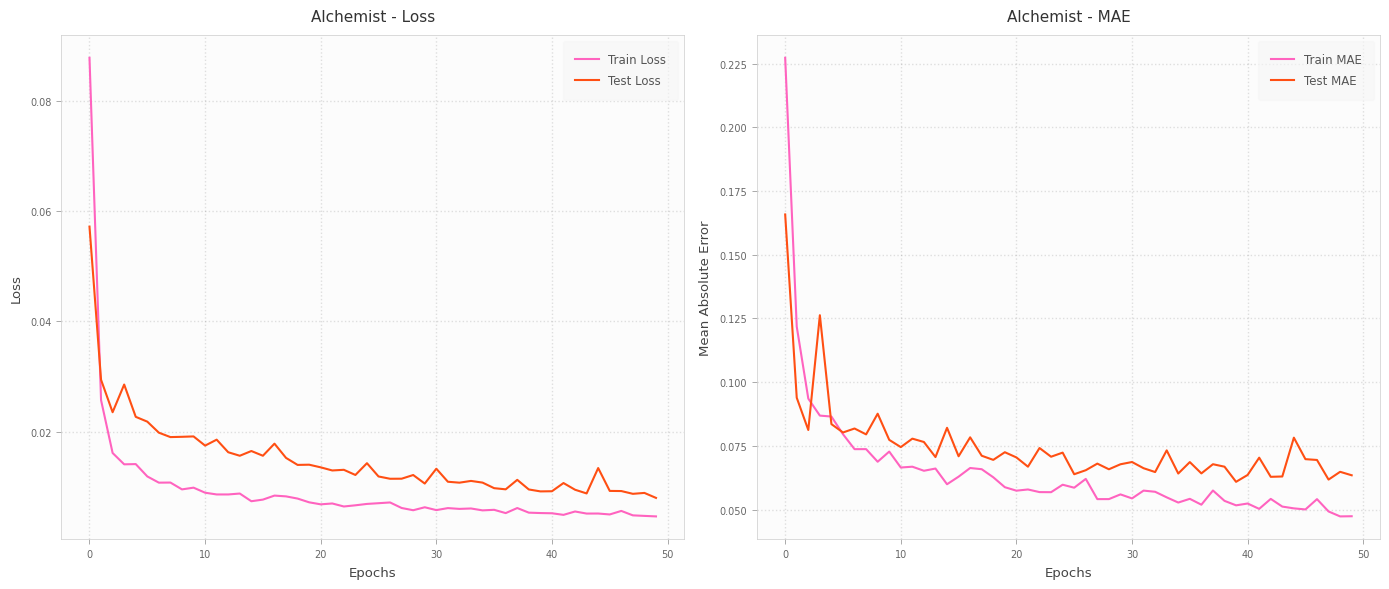

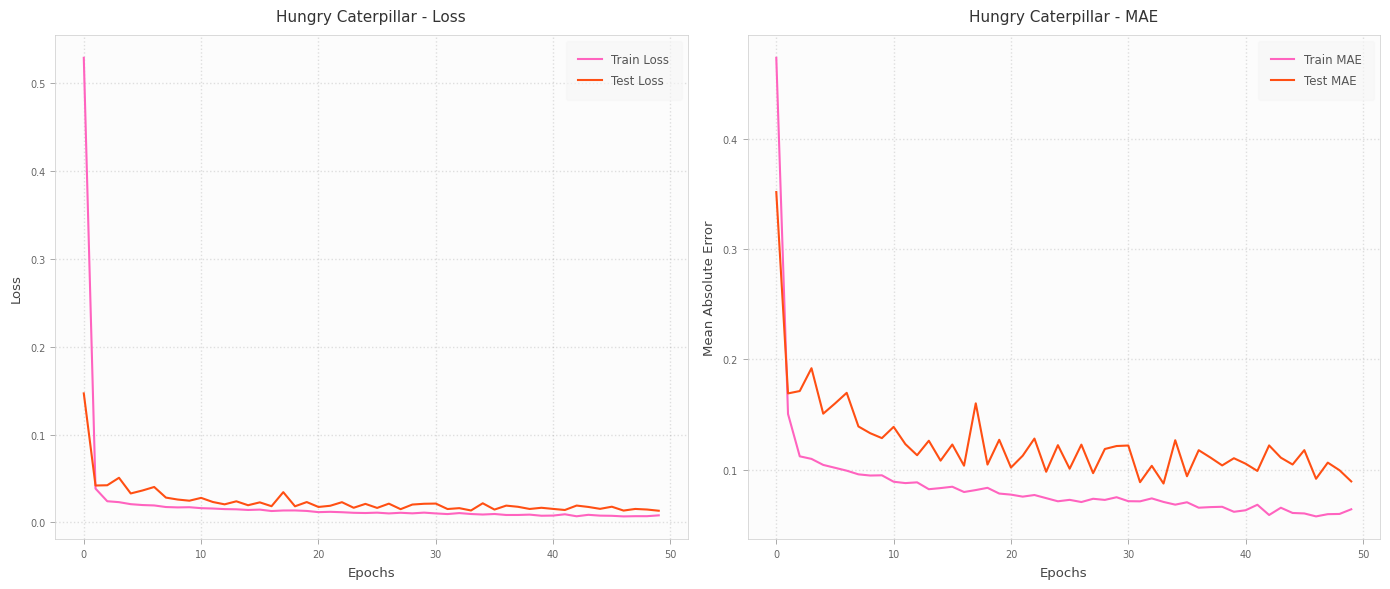

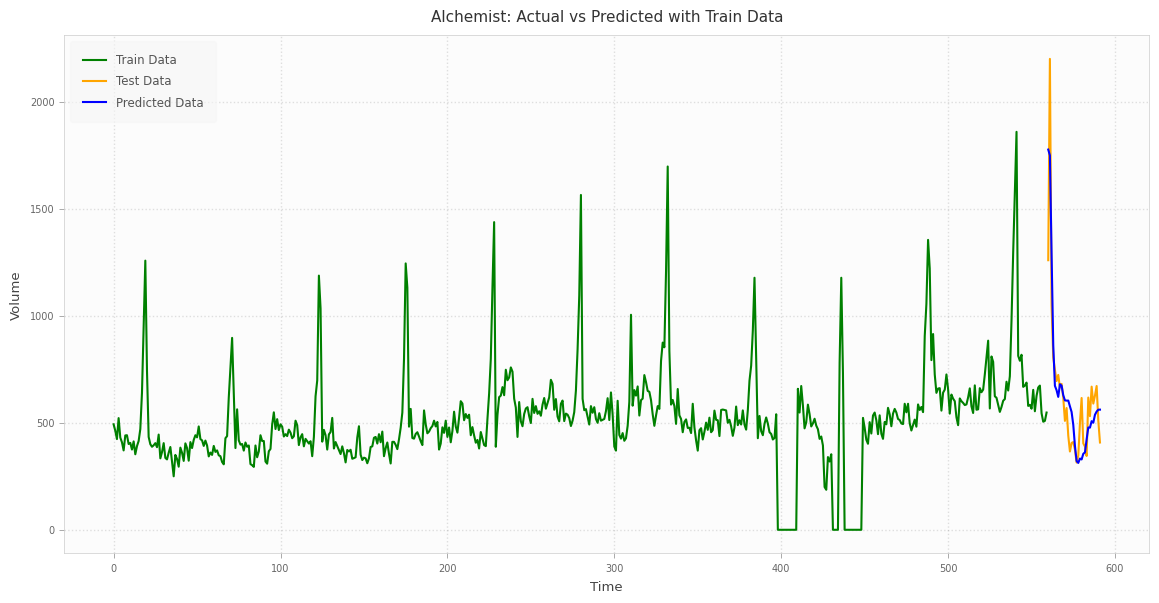

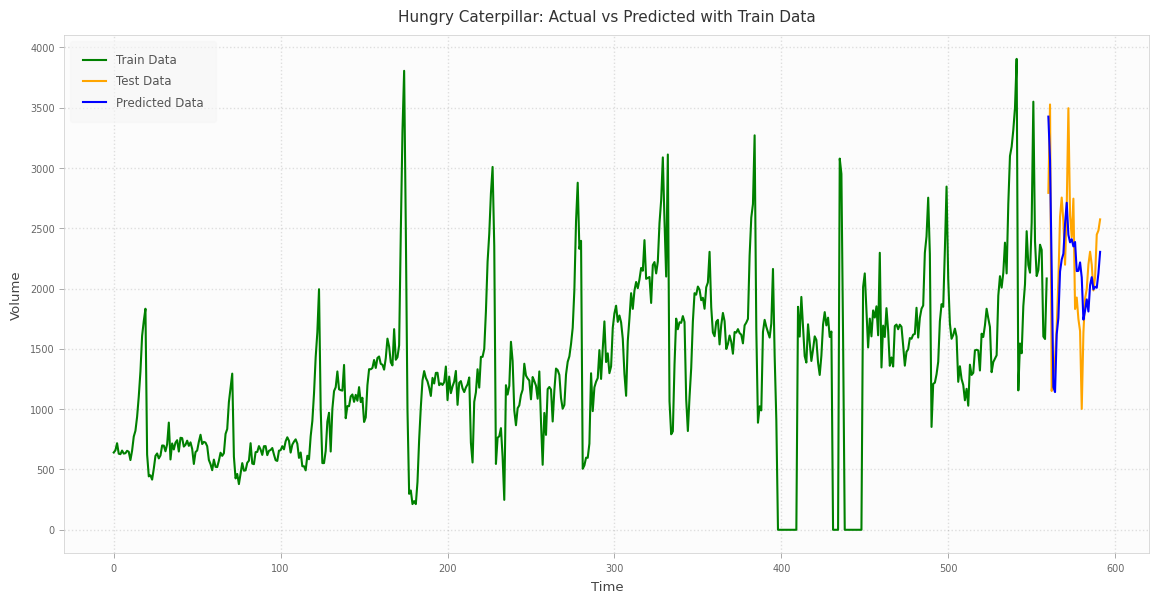

In [ ]:
mae_alc = mean_absolute_error(y_test_alc, y_pred_alc)
mape_alc = mean_absolute_percentage_error(y_test_alc, y_pred_alc)

mae_hcat = mean_absolute_error(y_test_hcat, y_pred_hcat)
mape_hcat = mean_absolute_percentage_error(y_test_hcat, y_pred_hcat)

print(f"Alchemist - MAE: {mae_alc:.2f}, MAPE: {mape_alc:.2%}")
print(f"Hungry Caterpillar - MAE: {mae_hcat:.2f}, MAPE: {mape_hcat:.2%}")

# Function to plot train and test metrics
def plot_training_metrics(history, title):
    plt.figure(figsize=(14, 6))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Test MAE')
    plt.title(f'{title} - MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training metrics
plot_training_metrics(history_alc, "Alchemist")
plot_training_metrics(history_hcat, "Hungry Caterpillar")

# Function to plot predictions with training and test data
def plot_predictions_with_train(y_train, y_test, y_pred, title):
    plt.figure(figsize=(14, 7))
    plt.plot(range(len(y_train)), y_train, label="Train Data", color="green")
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label="Test Data", color="orange")
    plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, label="Predicted Data", color="blue")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Volume")
    plt.legend()
    plt.show()

# Plot predictions
plot_predictions_with_train(y_train_actual_alc, y_test_alc, y_pred_alc, "Alchemist: Actual vs Predicted with Train Data")
plot_predictions_with_train(y_train_actual_hcat, y_test_hcat, y_pred_hcat, "Hungry Caterpillar: Actual vs Predicted with Train Data")


MAE (Mean Absolute Error): On average, *the Alchemist model* predictions are off by ~118 units, while *The Hungry Caterpillar's* are off by ~349 units.

MAPE (Mean Absolute Percentage Error): Both models have similar relative error (~18.5%), suggesting they’re proportionally equally accurate despite differences in scale.

*The Alchemist*

The forecast plot for The Alchemist shows a strong alignment between the predicted and actual test values. The model captures overall trends and seasonal patterns fairly well, with minimal deviation from the actuals in the test set.

The prediction line (in blue) closely tracks the actuals (orange), which indicates that the model is generalising well to unseen data.
This level of alignment, combined with a low MAE, suggests the data is relatively stable and predictable, which the model handles effectively.

*The Hungry Caterpillar*

This dataset presents more volatility, with sharper peaks and greater fluctuations in volume. Visually, the model captures the general direction and pattern of the series, but it tends to smooth out the extremes.

While the blue prediction line does follow the shape of the actual values, it falls short of fully capturing the highest spikes.
This is reflected in the higher MAE, though the relative error (MAPE) remains on par with The Alchemist.


**Considerations**

*The Alchemist’s* model performs strongly both in absolute and relative terms. The consistency in volume likely contributes to the model's ability to learn seasonality and trends effectively.

The *Hungry Caterpillar’s* model, while proportionally accurate, struggles with the magnitude of volume spikes. These may be driven by factors not captured in the model—such as special events, promotions, or external influences.

###**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

##**Final considerations**



Time series modelling is a valuable tool for forecasting consumer demand as it captures historical patterns and trends to predict future outcomes.

**Key highlights:**

*   **Data Complexity:** The Caterpillar dataset has intricate patterns, making it more complex for time series models to predict accurately. To improve model accuracy additional explanatory factors added to the model might be required to interpret the consumer demand for this book.

*   **Flexibility:** XGBoost and LSTM excel at capturing non-linear patterns, unlike ARIMA's linear approach.

*   **Feature engineering**, such as incorporating lags and rolling statistics, enhances models like XGBoost and LSTM, while simple ARIMA primarily depends on historical values.

*   **Long-Term Dependencies:** LSTM captures sequential dependencies, making it ideal for complex datasets.